## Run all import statements

In [1]:
#!jupyter nbconvert --to script pythiaTesting.ipynb
#import ROOT
#import uproot as ur
import numpy as np
import pandas as pd
from particle import Particle
from particle import PythiaID
from particle import PDGID
from particle.converters import Pythia2PDGIDBiMap
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import qgrid
#import networkx as nx
#import pydot
#from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
#import pyarrow as pa
#import urllib.request

## Helper functions

In [2]:
def getEvents(filedir, filename, treename):
    return NanoEventsFactory.from_root(filedir + filename, treepath = treename, schemaclass = DelphesSchema).events()

def hist2fit(hist):
    elements = (hist[1][1:] + hist[1][:-1])/2
    frequencies = hist[0]

    newfrequencies = frequencies[frequencies !=0]
    newelements = elements[frequencies !=0]

    slope, intercept = np.polyfit(newelements, np.log(newfrequencies), deg = 1, w = newfrequencies)
    return 1/np.abs(slope)

def labrest(pdgid, ctawk):
    fields = ["decayX", "X", "decayY", "Y", "decayZ", "Z", "decayT", "T", "ctau"]

    llpawk = ctawk[ctawk.PID == pdgid]

    decayLength = np.sqrt((llpawk.decayX - llpawk.X)**2 
                        + (llpawk.decayY - llpawk.Y)**2
                        + (llpawk.decayZ - llpawk.Z)**2)

    decayTime = llpawk.decayT-llpawk.T

    fig, (xyz_ax, ltau_ax, ctau_ax) = plt.subplots(1, 3, figsize = (5*3,5))
    xyz_hist  =  xyz_ax.hist(ak.flatten(decayLength), log = True)
    ltau_hist = ltau_ax.hist(ak.flatten(decayTime*2.998e11), log = True)
    ctau_hist = ctau_ax.hist(ak.flatten(llpawk.ctau), log = True)

    xyz_ax.set_title('Lab Decay Dist.', usetex = True, fontsize = 20)
    ltau_ax.set_title('Lab Decay Time', usetex = True, fontsize = 20)
    ctau_ax.set_title('Rest Decay Time', usetex = True, fontsize = 20)

    xyz_ax.set_ylabel('Num events', usetex = True, fontsize = 20)

    xyz_ax.set_xlabel('mm', usetex = True, fontsize = 20)
    ltau_ax.set_xlabel('mm', usetex = True, fontsize = 20)
    ctau_ax.set_xlabel('mm', usetex = True, fontsize = 20)
    fig.show()


    print("Lab Dist  ≈ " + str(hist2fit(xyz_hist)) + " mm")
    print("Lab Time  ≈ " + str(hist2fit(ltau_hist)) + " mm")
    print("Rest Time ≈ " + str(hist2fit(ctau_hist)) + " mm")
    
def particlehists(pdgids, ctawk):
    fields = ["E", "PT", "Eta", "Phi"]
    x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$"]
    titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for "]

    for pdgid in pdgids:
        mask = (ctawk.PID == pdgid)
        if ak.sum(mask) != 0:
            fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
            fig[1][0].set_ylabel('Events for ' + '$' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
            for i in range(len(fields)):
                fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
                fig[1][i].set_title(titles[i] + ' $' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
                fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
                #fig[1][i].set_ylim([0, 1])
            fig[0].show()

def llphists(pdgids, ctawk):
    fields = ["E", "PT", "Eta", "Phi", "decayT", "ctau"]
    x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$", "$\\tau$", "$c\\tau$"]
    titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for ", "Lab decay", "Rest decay"]

    mask = (ctawk.PID == pdgid)
    if ak.sum(mask) != 0:
        fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
        fig[1][0].set_ylabel('Num events', usetex = True, fontsize = 20)
        for i in range(len(fields)):
            hist = fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), bins = 100, log = True)
            fig[1][i].set_title(titles[i] + ' $LLP$', usetex = True, fontsize = 20)
            fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
            #fig[1][i].set_xlim([0, 100])
        fig[0].show()
    else:
        print("there's no llp here!")
    plt.show()
    
    return hist

## Imports the four MC gen level data into awkward datasets

In [3]:
filedir   = "root://cms-xrd-global.cern.ch//store/user/christiw/BDecay_delphes/v1/"
filenames = ["m1_ct10000mm.root", "m1_ct1000mm.root", "m1_ct100mm.root", "m1_ct10mm.root"]
treename  = "Delphes"


ct_10000 = getEvents(filedir, filenames[0], treename)
ct_1000  = getEvents(filedir, filenames[1], treename)
ct_100   = getEvents(filedir, filenames[2], treename)
ct_10    = getEvents(filedir, filenames[3], treename)

## B hadrons (both legs), energy, pt, eta, phi

### ct_10000

In [24]:
llp_ID = 1500001
mu_ID = 13
PT_cut = 8
ct_awk = ct_10000.Particle

# all particles in all events that are LLPs
llp_mask = ct_awk.PID == llp_ID
llp_awk = ct_awk[llp_mask]

# all muons in all events with pt >= 8GeV
mu_mask = ((ct_awk.PID == mu_ID)+(ct_awk.PID == -mu_ID))*(ct_awk.PT >= PT_cut)
mu_awk = ct_awk[mu_mask]

# all parents that have LLPs as kids
P_llp_ind1 = llp_awk.M1[llp_awk.M1 != -1]
P_llp_ind2 = llp_awk.M2[llp_awk.M2 != -1]
P_llp_ind = ak.concatenate([P_llp_ind1, P_llp_ind2], axis = 1)
P_llp_awk = ct_awk[P_llp_ind]

# all parents that have >8GeV muons as kids
P_mu_ind1 = mu_awk.M1[mu_awk.M1 != -1]
P_mu_ind2 = mu_awk.M2[mu_awk.M2 != -1]
P_mu_ind = ak.concatenate([P_mu_ind1, P_mu_ind2], axis = 1)
P_mu_awk = ct_awk[P_mu_ind]

# intersection of parents that can have either LLPs or >8GeV muons as kids
P_llp_IDs = set(ak.flatten(P_llp_awk.PID))
P_mu_IDs = set(ak.flatten(P_mu_awk.PID))
P_pids = P_llp_IDs.intersection(P_mu_IDs)
P_mask = ak.values_astype(sum([ct_awk.PID == pid for pid in P_pids]), bool)
P_awk = ct_awk[P_mask]




def hist(awk, fields, x_axis, titles):
    fields = ["E", "PT", "Eta", "Phi"]
    x_axis = ["$GeV$", "$Gev$", "$\eta$", "$\phi$"]
    titles = ["$Energy$ for ", "$P_{T}$ for ", "$\eta$ for ", "$\phi$ for "]
    
    
    
    
    for pdgid in pdgids:
        mask = (ctawk.PID == pdgid)
        if ak.sum(mask) != 0:
            fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))
            fig[1][0].set_ylabel('Events for ' + '$' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
            for i in range(len(fields)):
                fig[1][i].hist(ak.flatten(ctawk[mask][fields[i]]), log = True)
                fig[1][i].set_title(titles[i] + ' $' + Particle.from_pdgid(PDGID(pdgid)).latex_name + '$', usetex = True, fontsize = 20)
                fig[1][i].set_xlabel(x_axis[i], fontsize = 20, usetex = True)
                #fig[1][i].set_ylim([0, 1])
            fig[0].show()







In [26]:
set(ak.flatten(P_awk.Status))

{2}

In [23]:
set(ak.flatten(P_awk.PID))

array([-531, -511,  511,  531], dtype=int32)

### ct_1000

/tmp/ipykernel_10497/1616479394.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


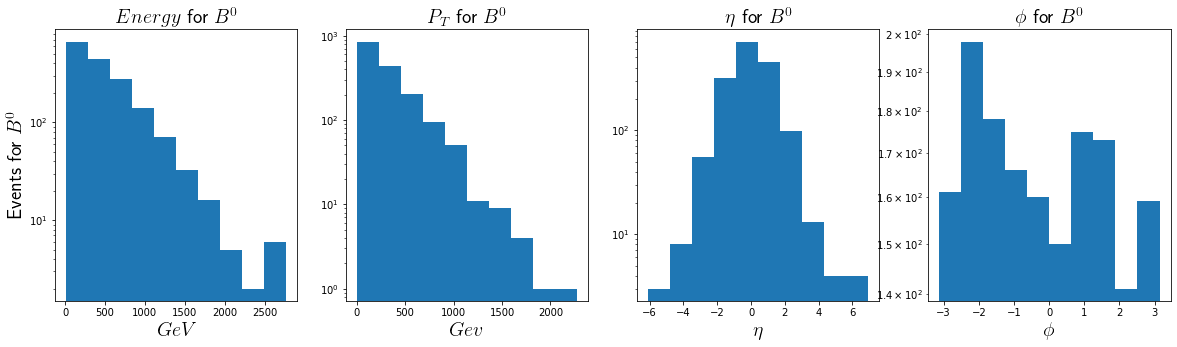

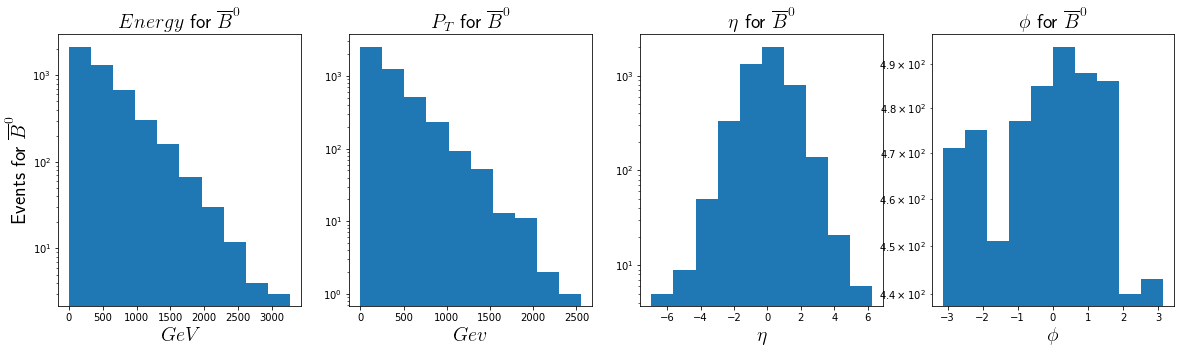

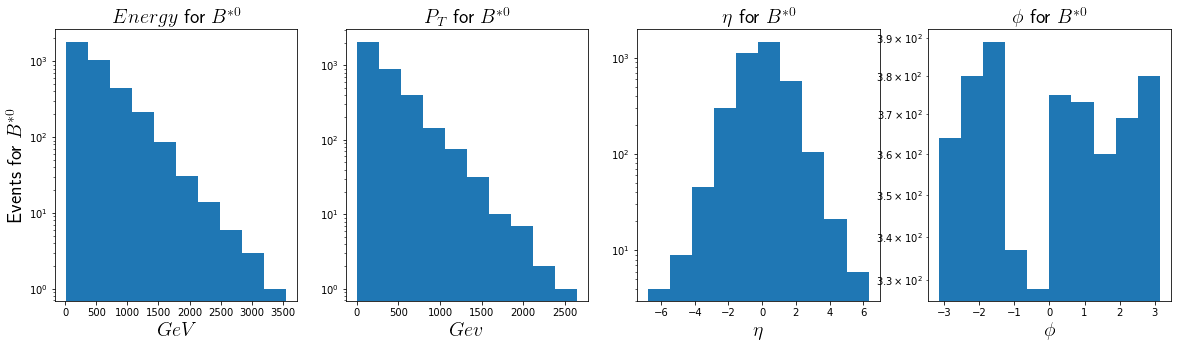

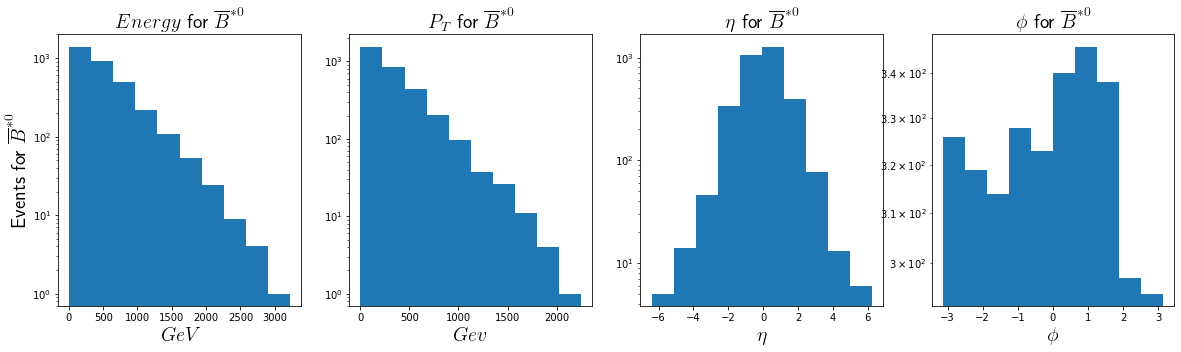

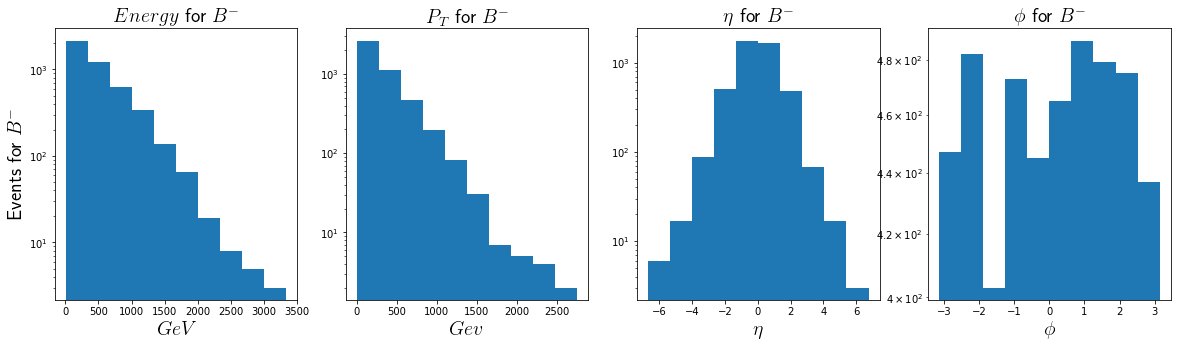

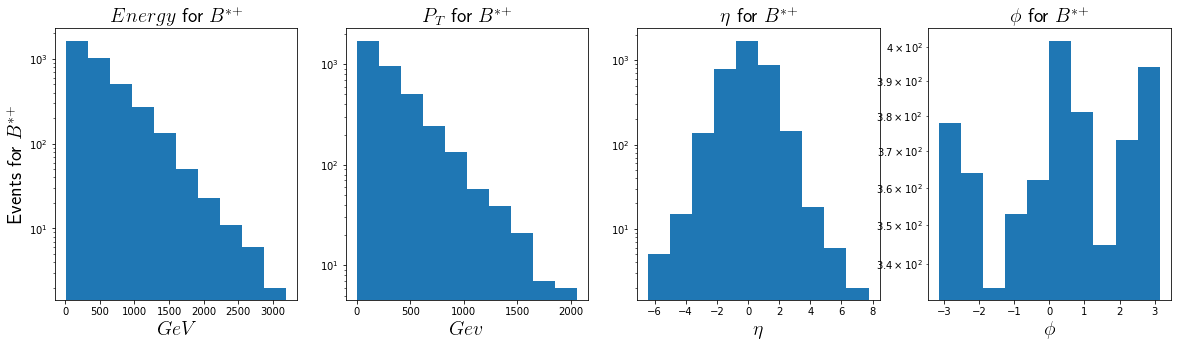

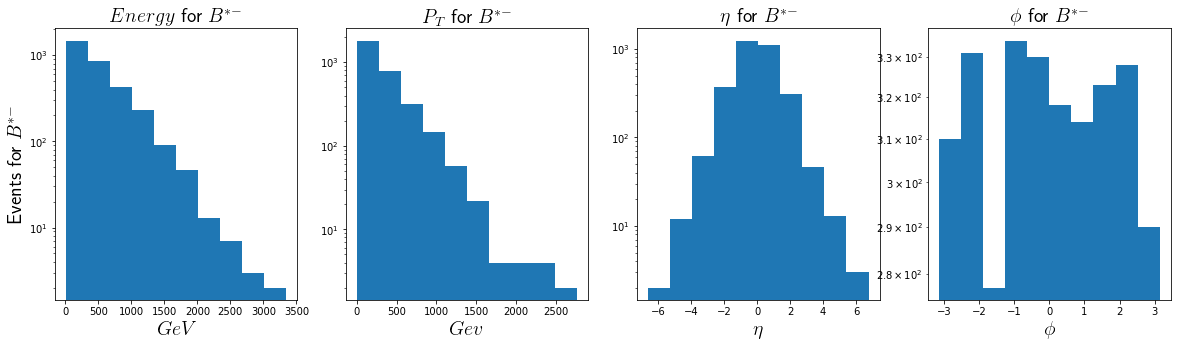

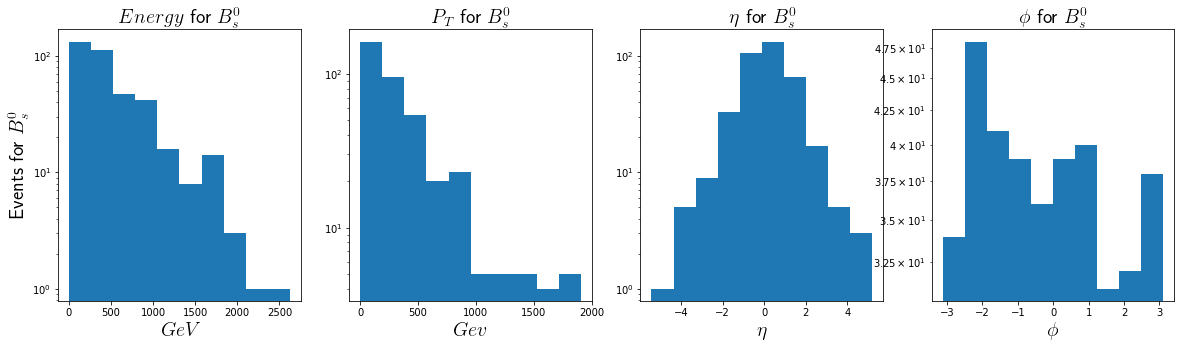

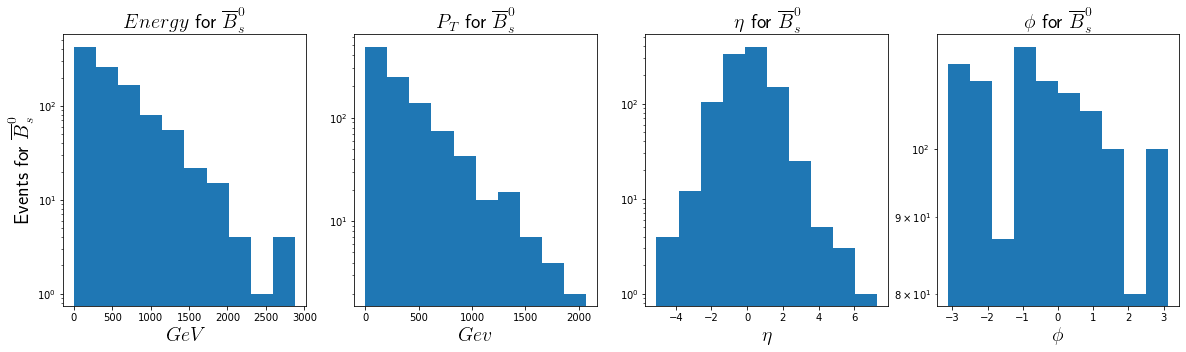

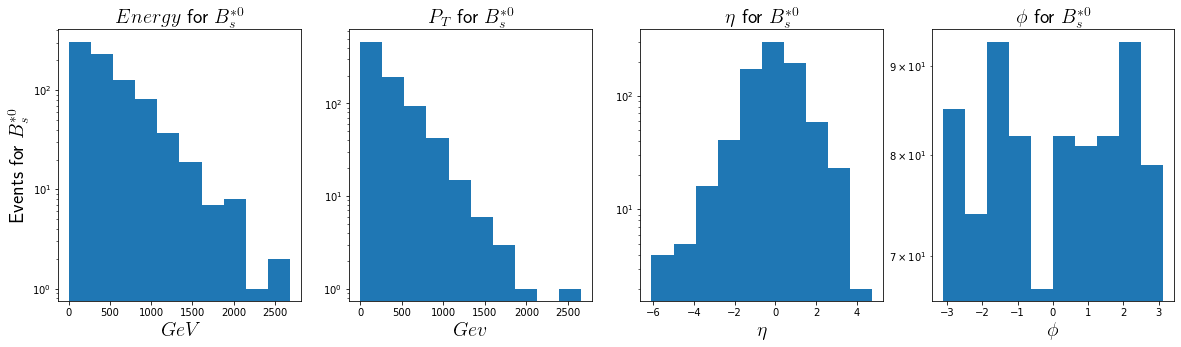

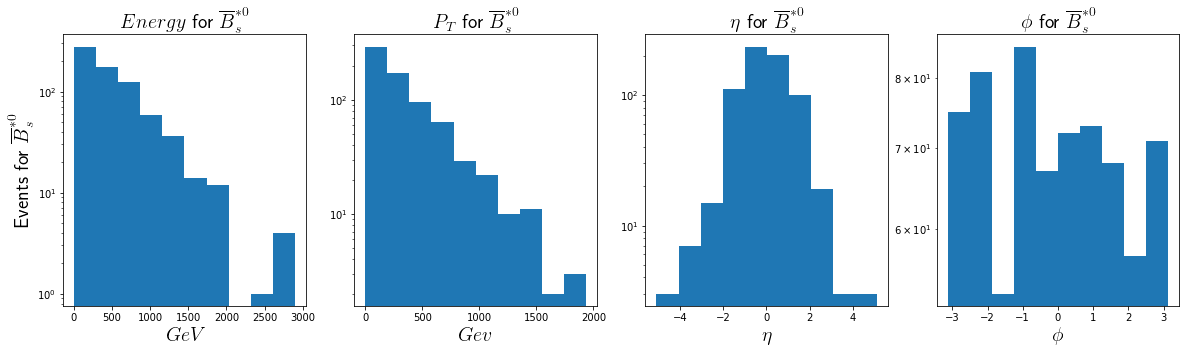

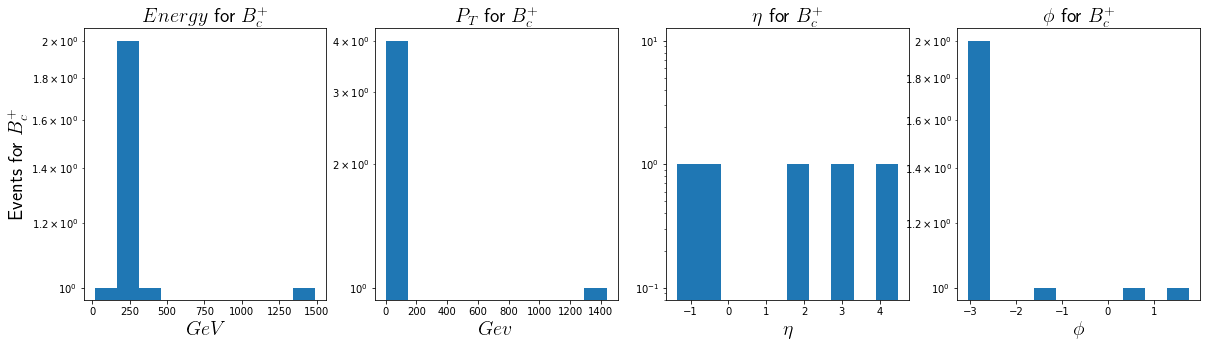

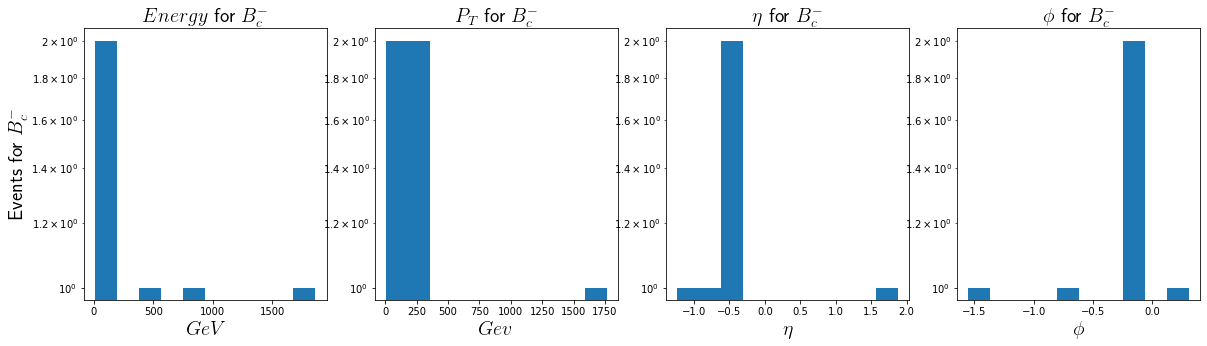

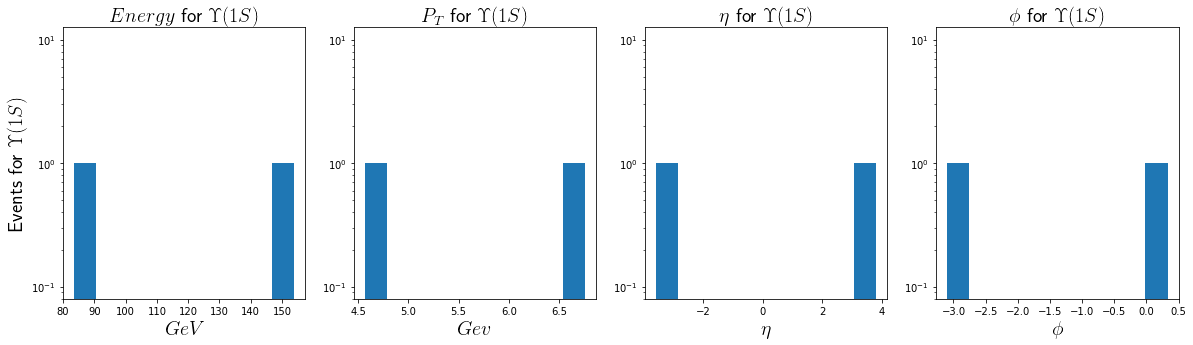

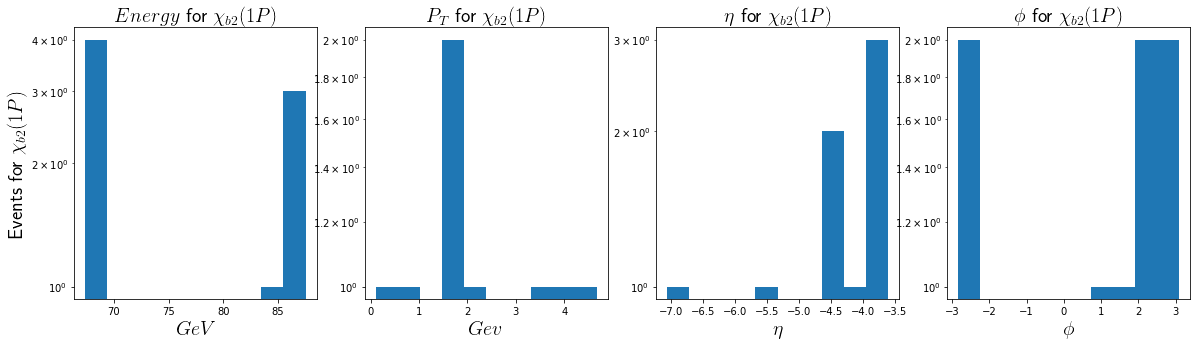

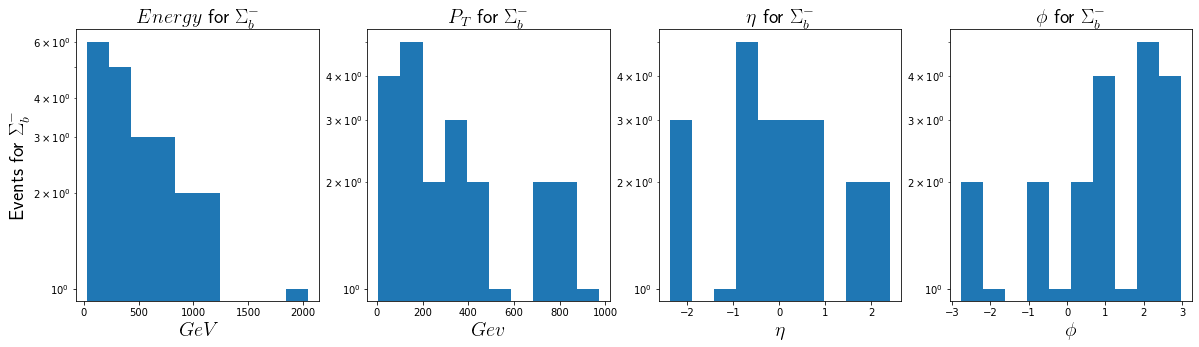

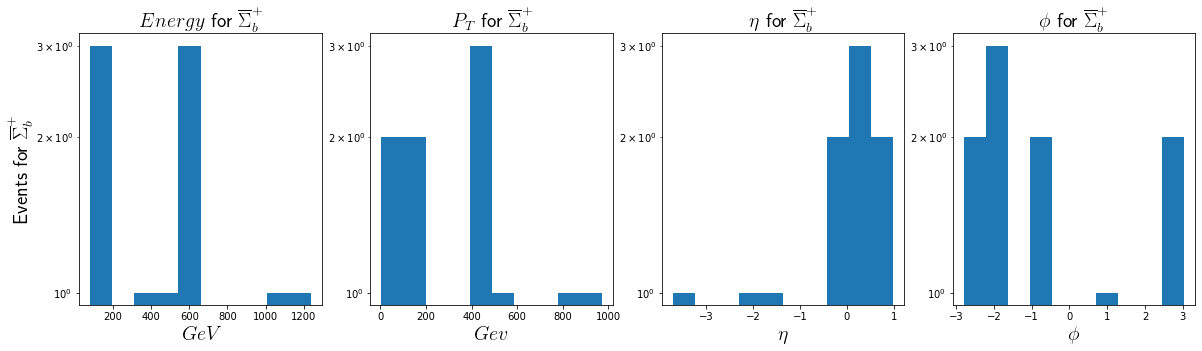

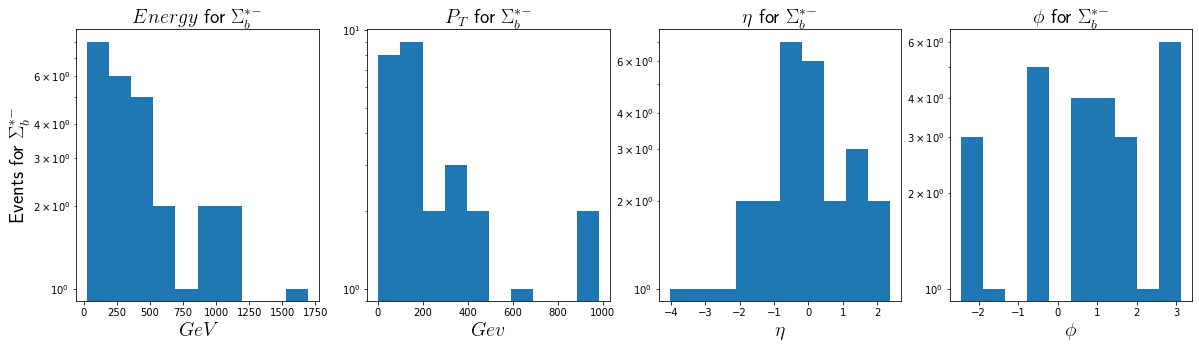

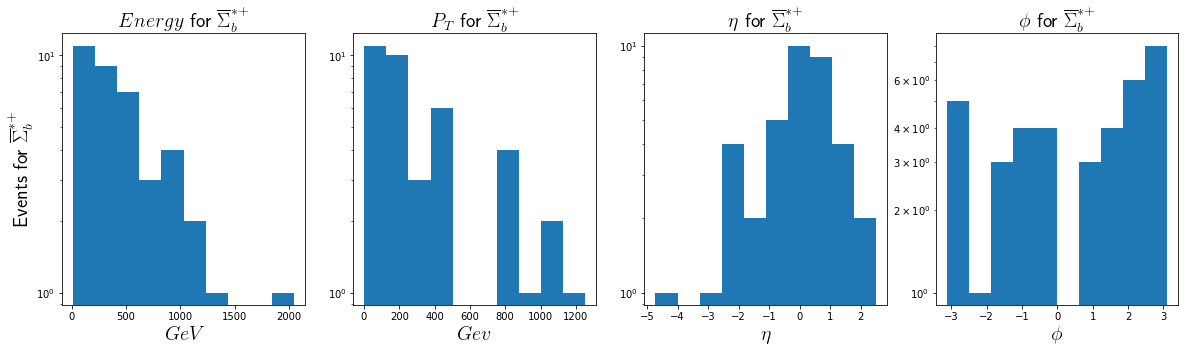

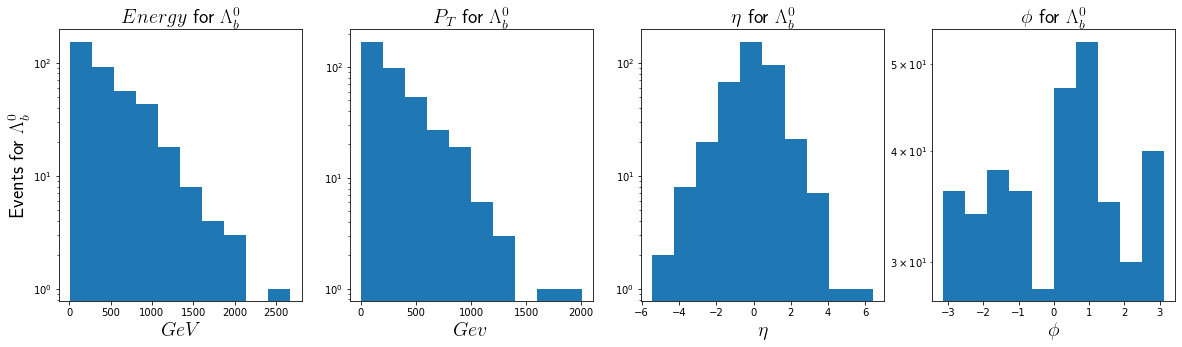

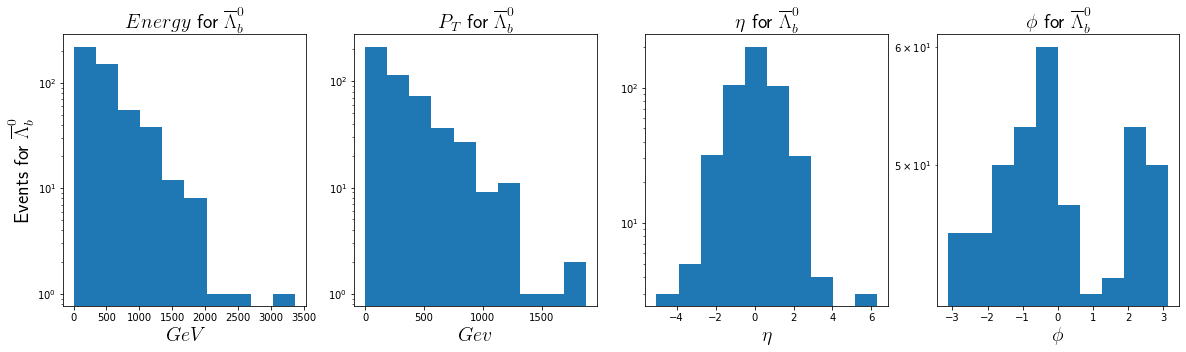

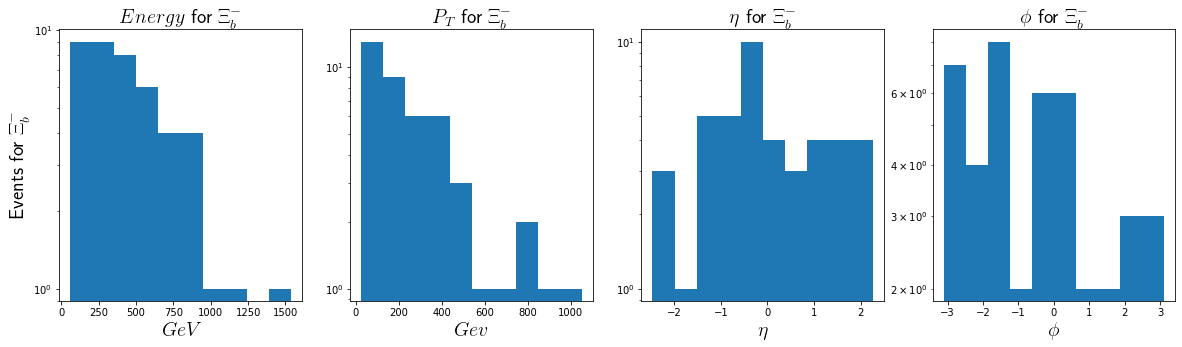

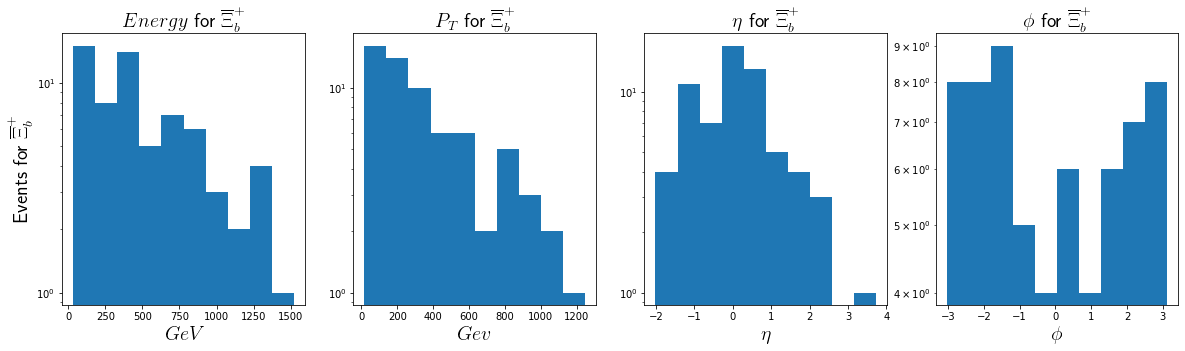

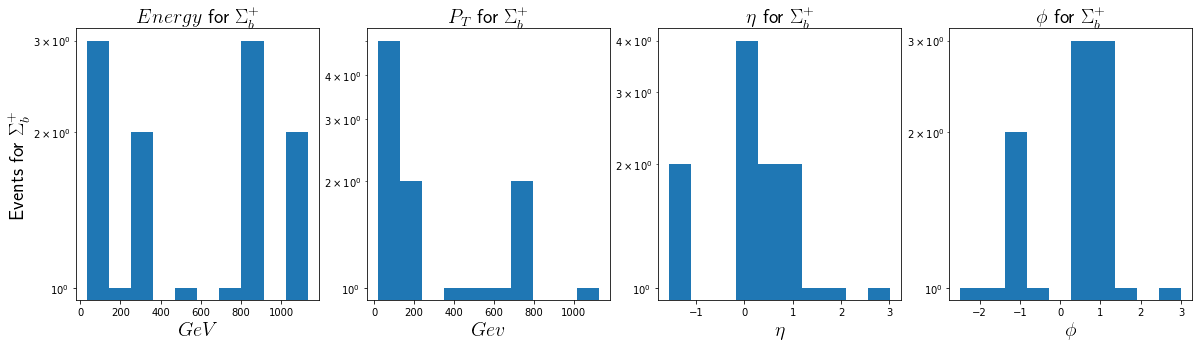

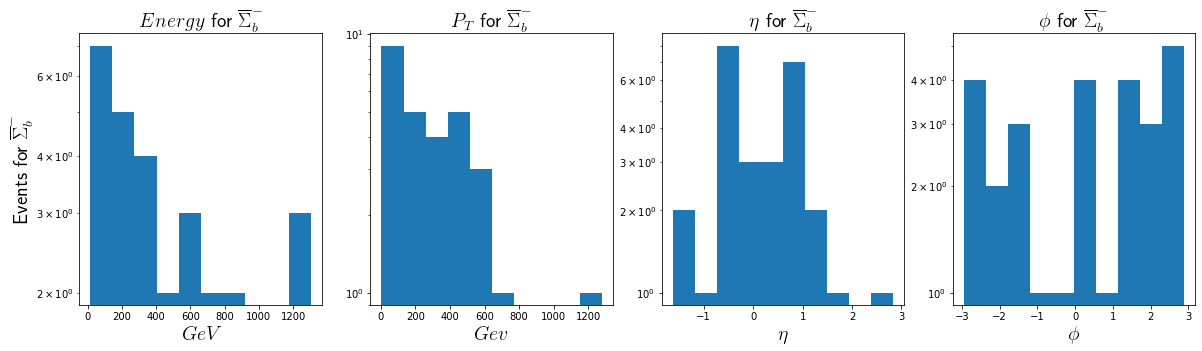

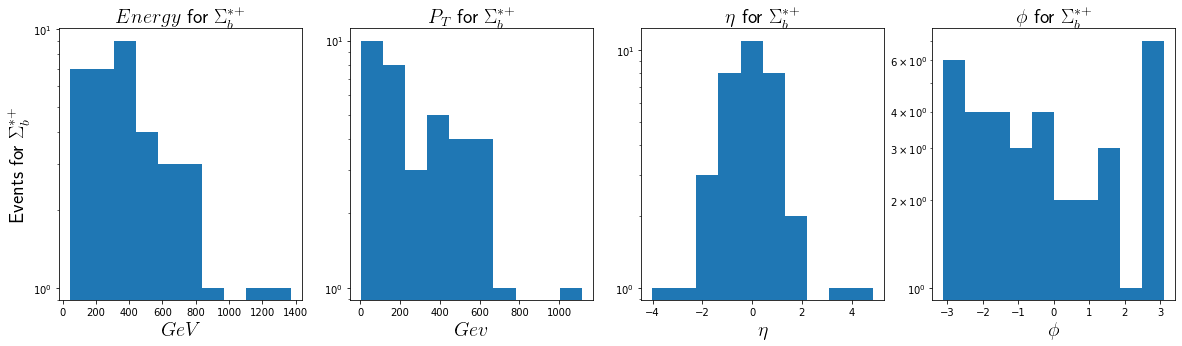

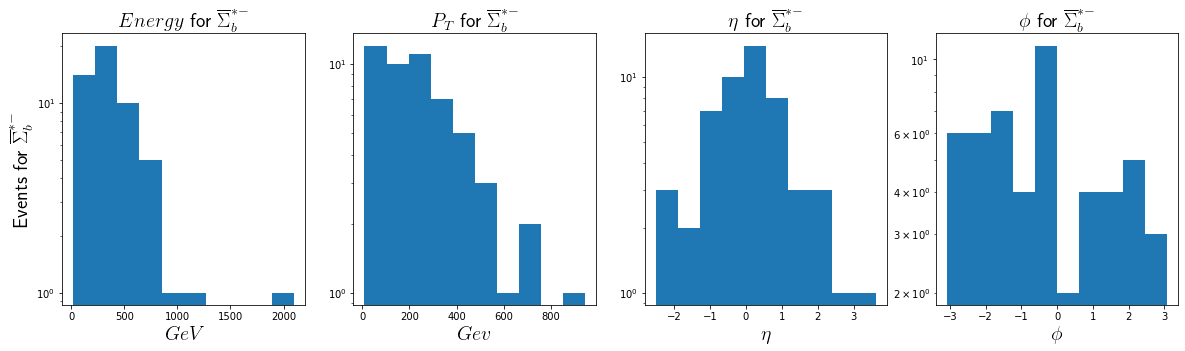

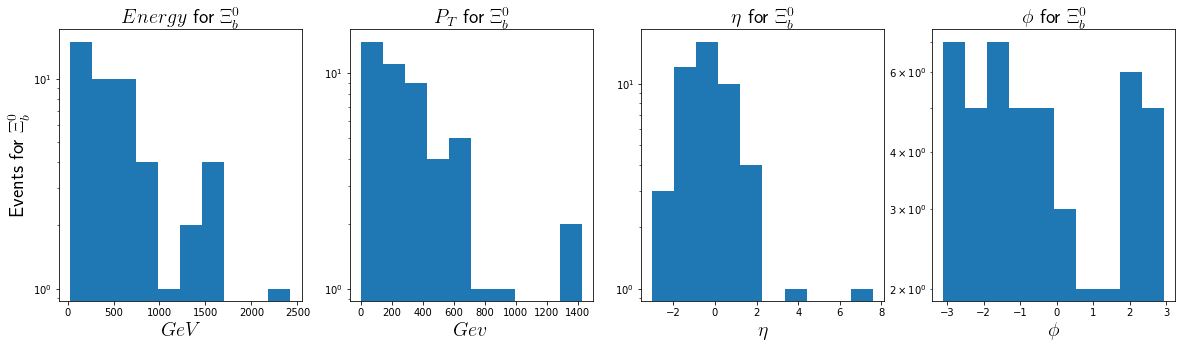

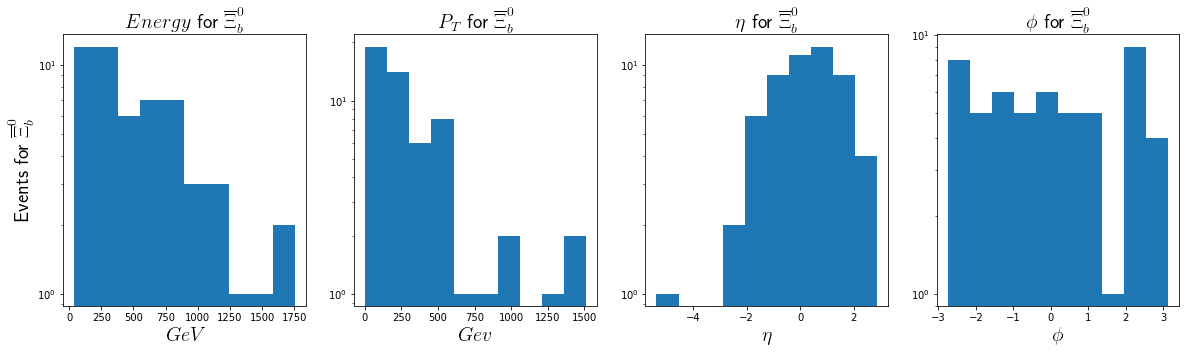

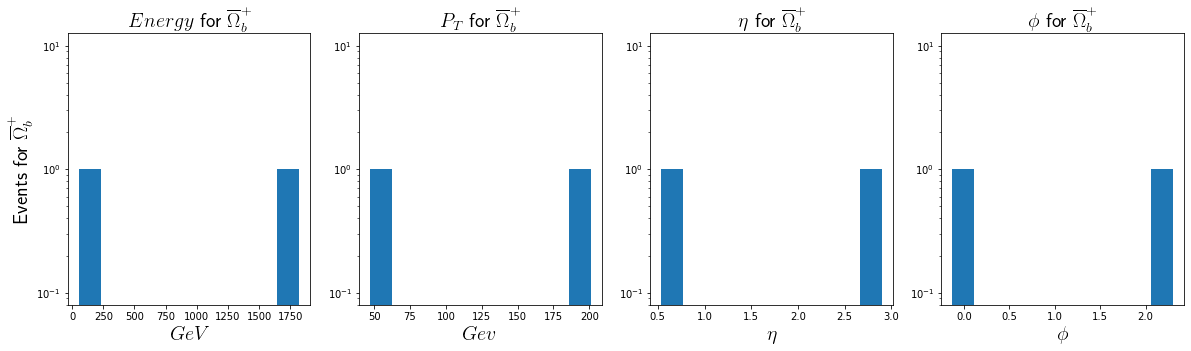

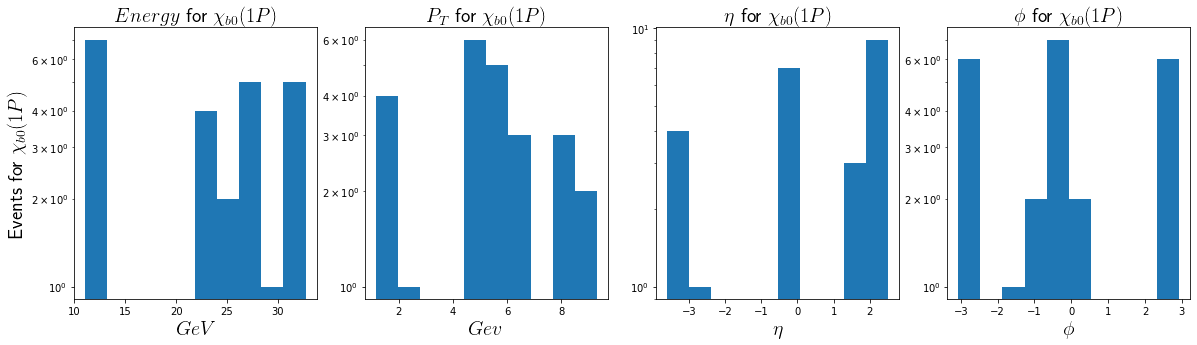

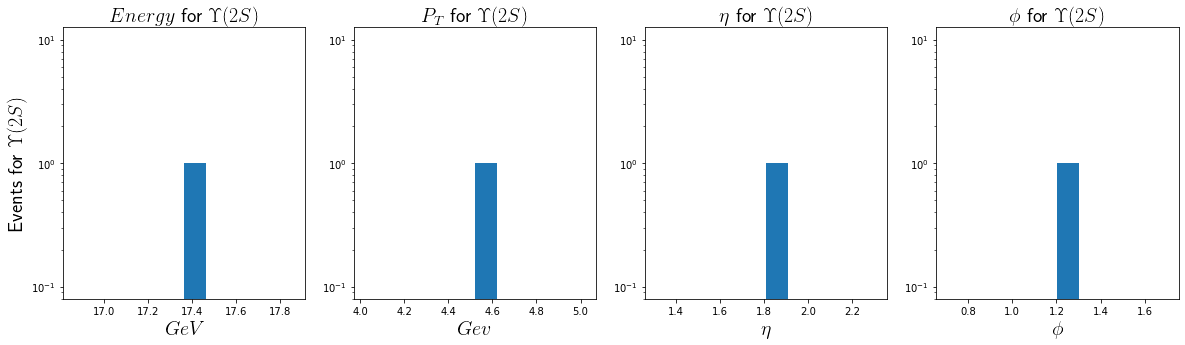

In [80]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_1000.Particle
particlehists(pdgids, ctawk)

### ct_100

/tmp/ipykernel_10497/1616479394.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


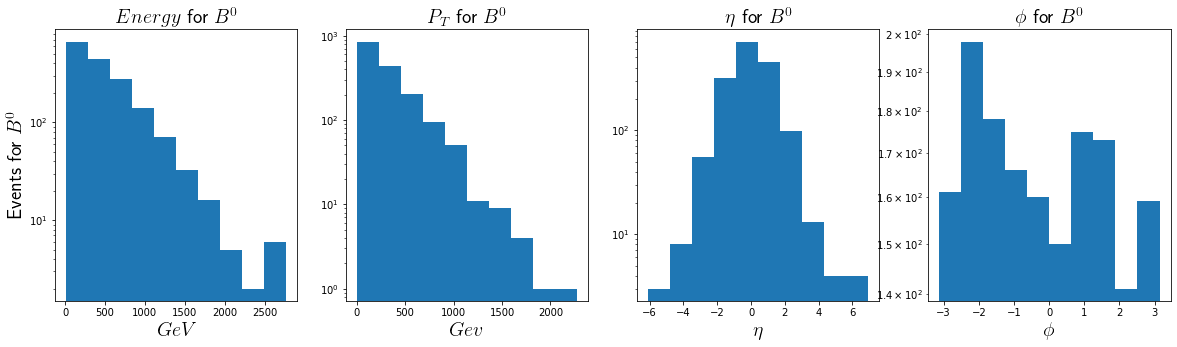

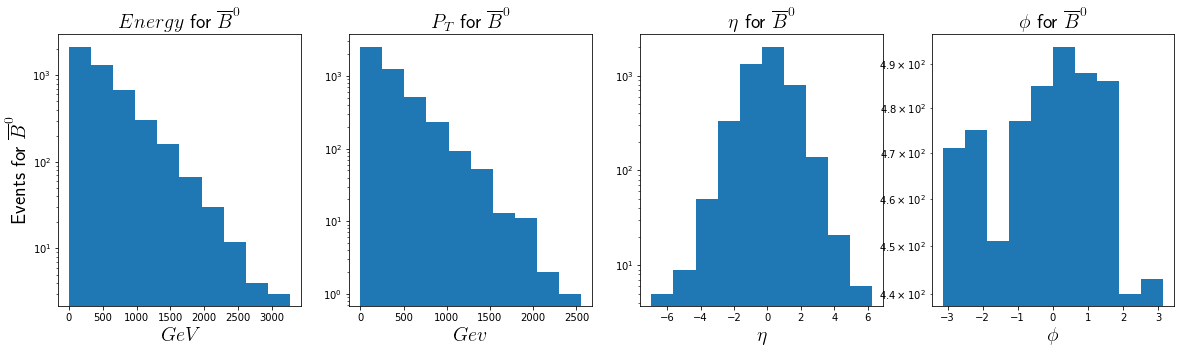

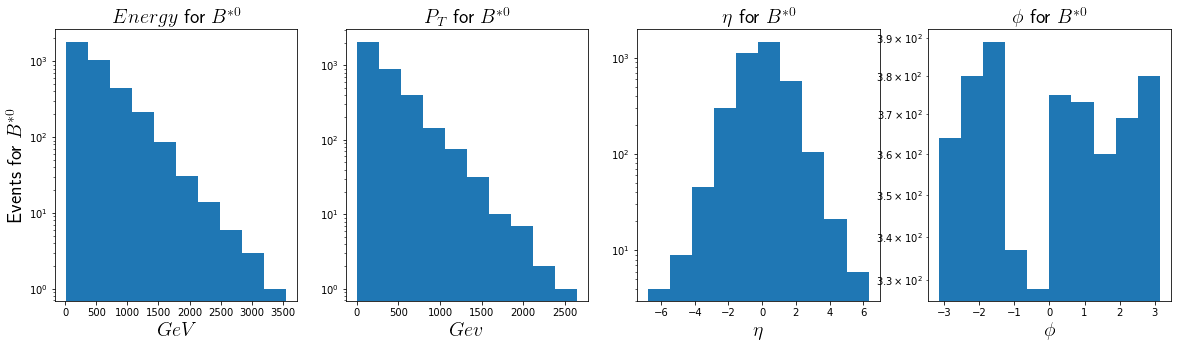

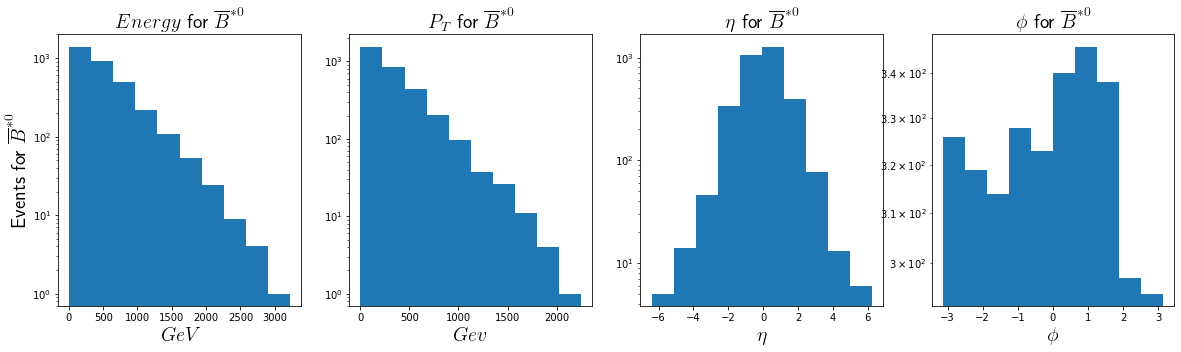

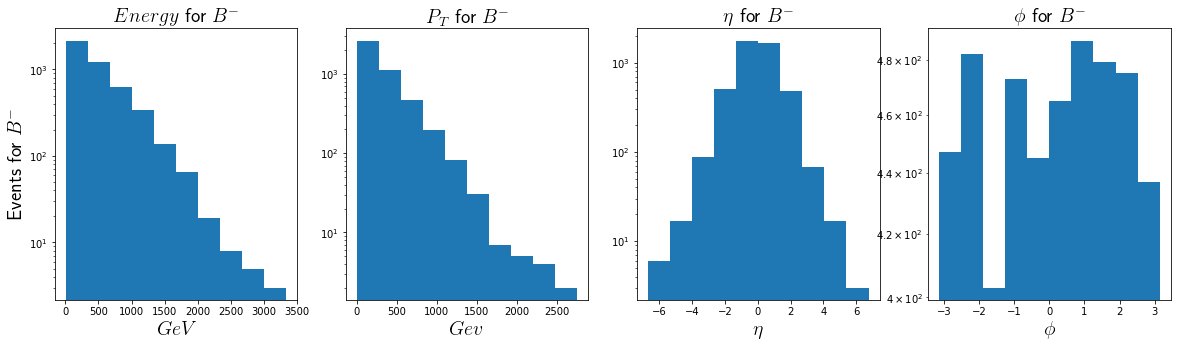

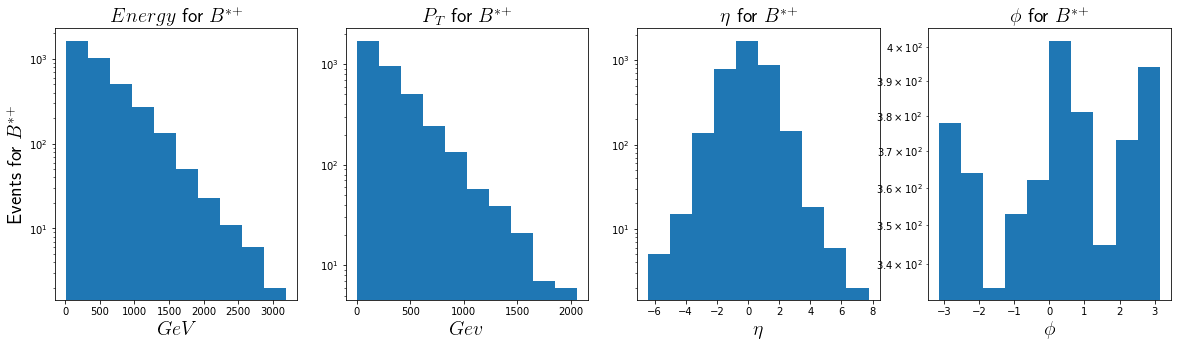

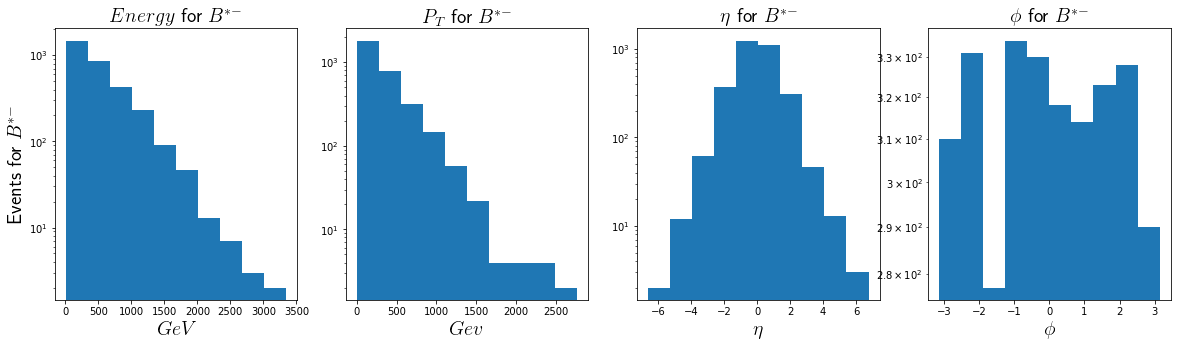

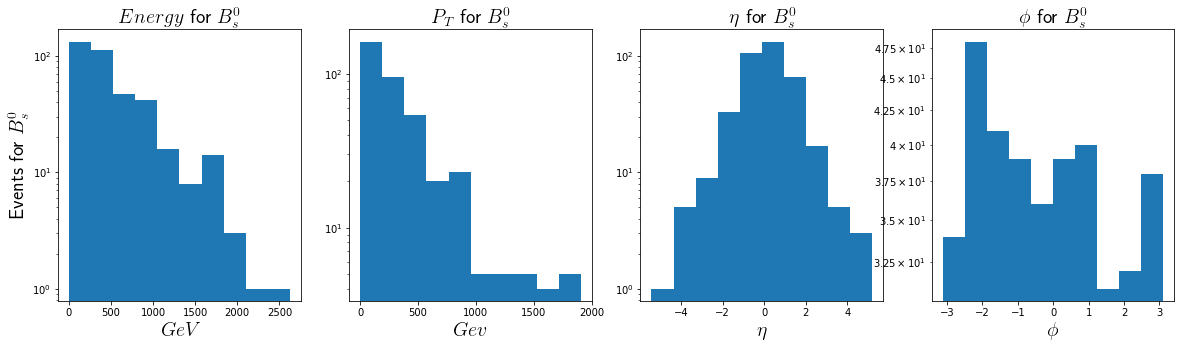

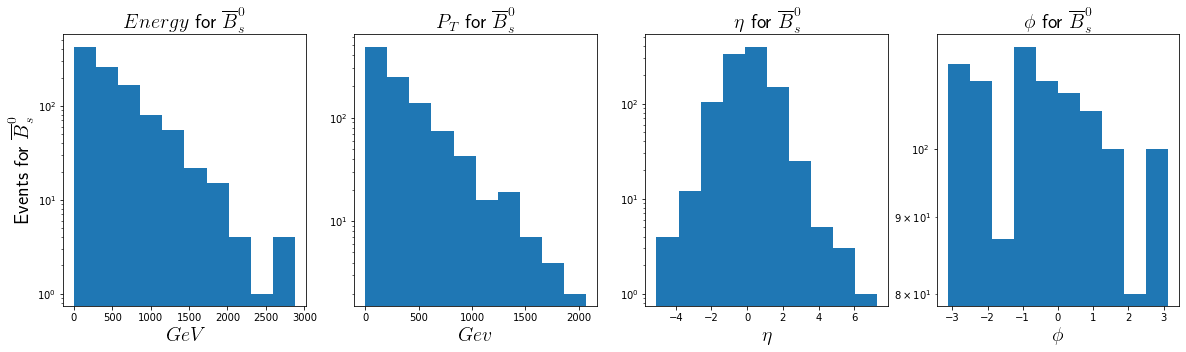

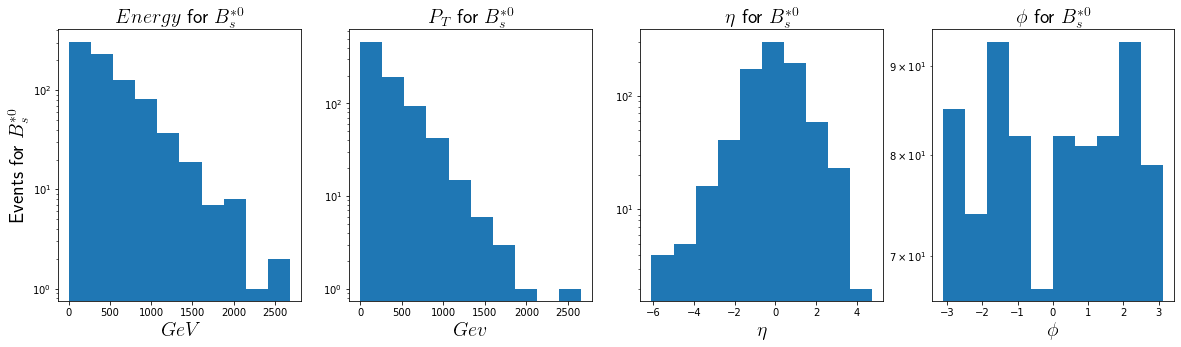

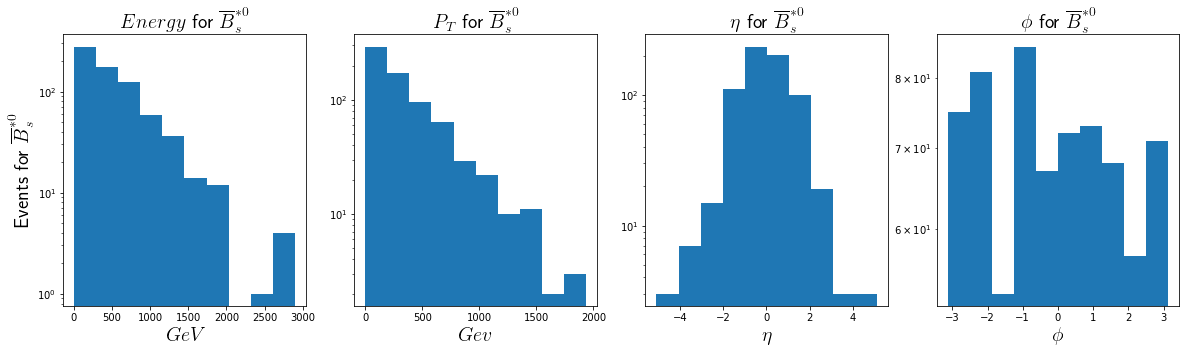

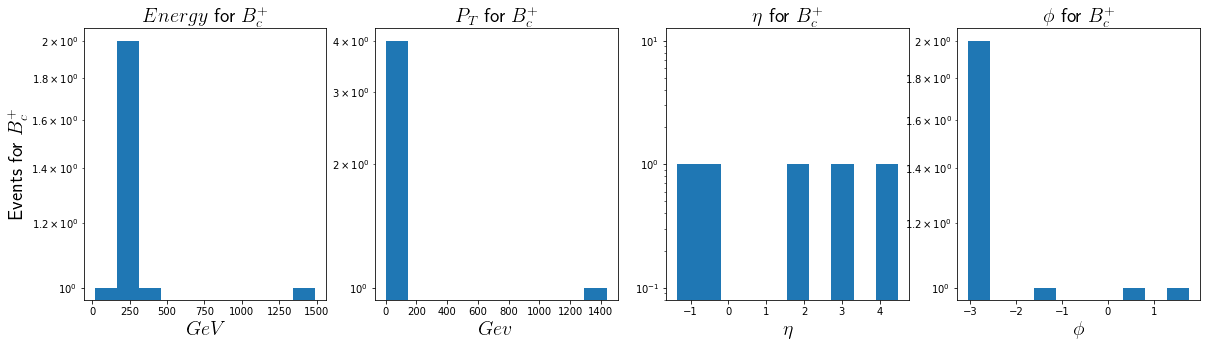

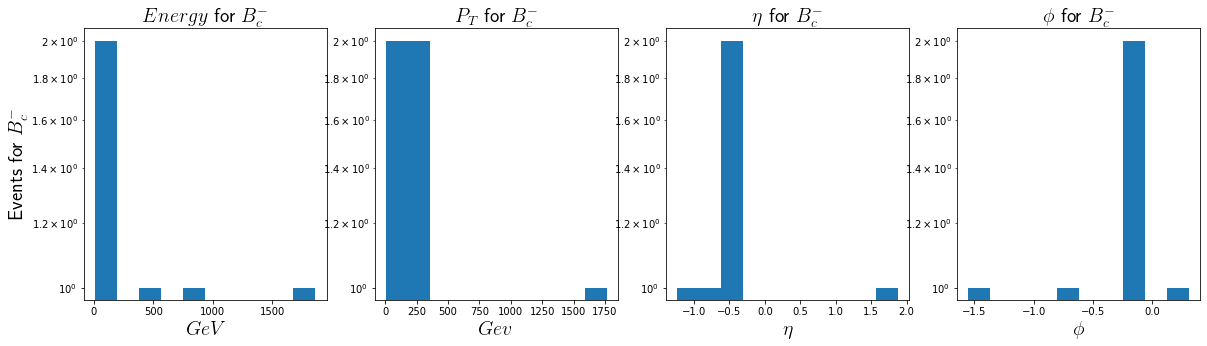

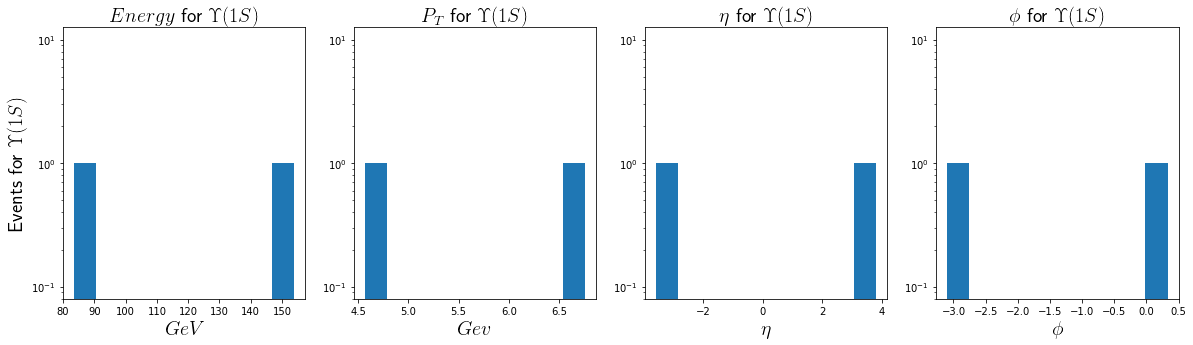

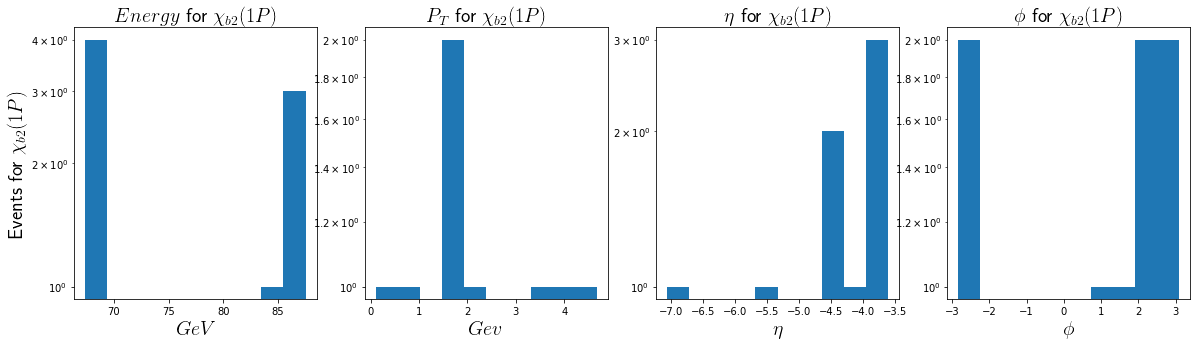

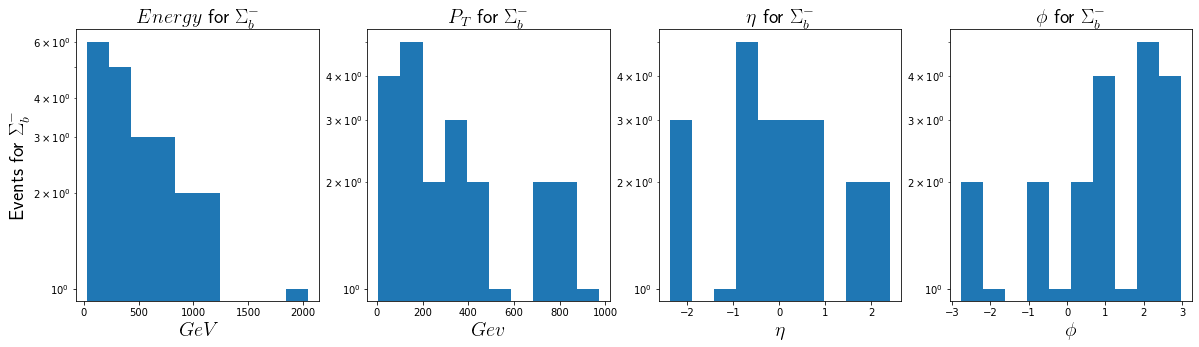

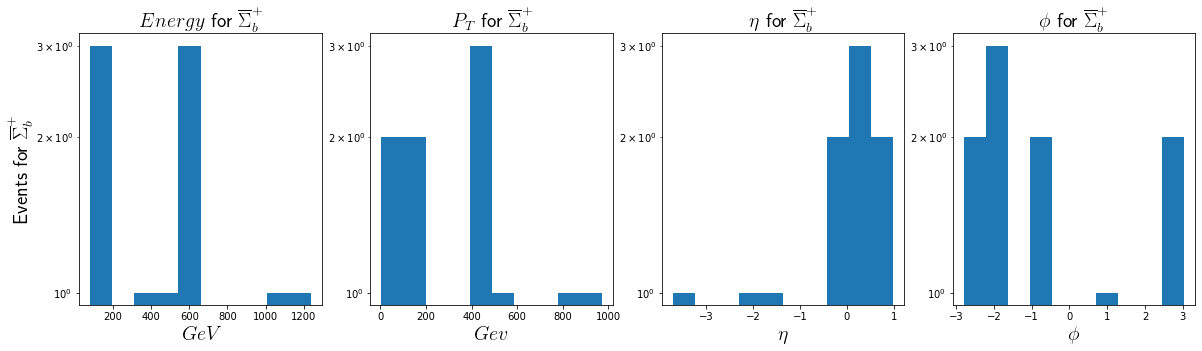

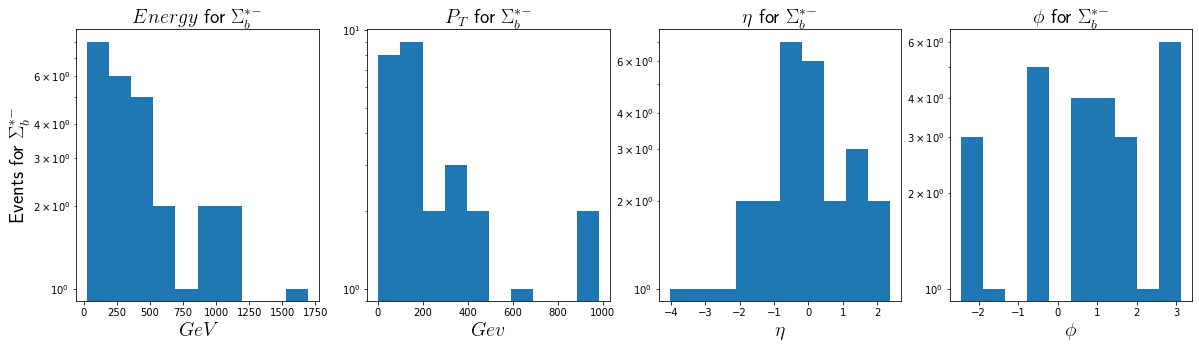

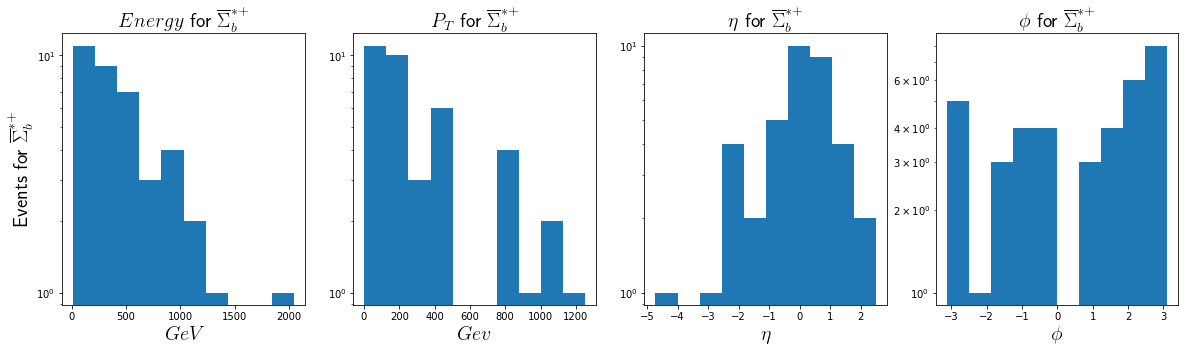

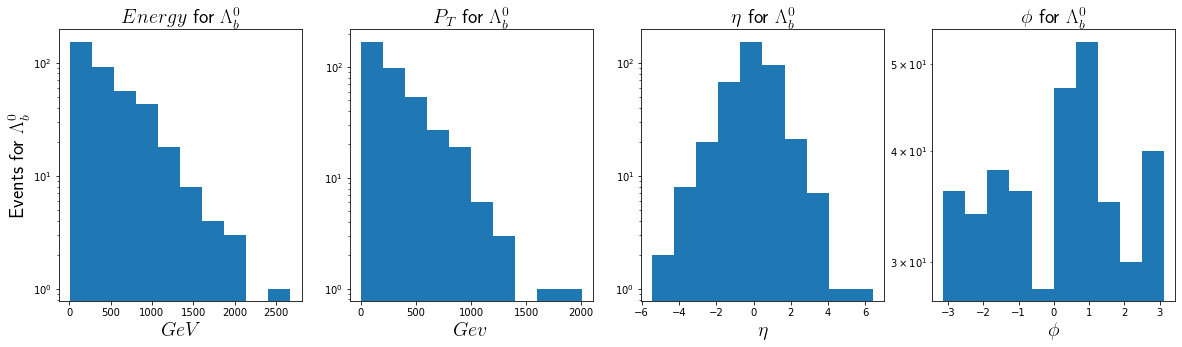

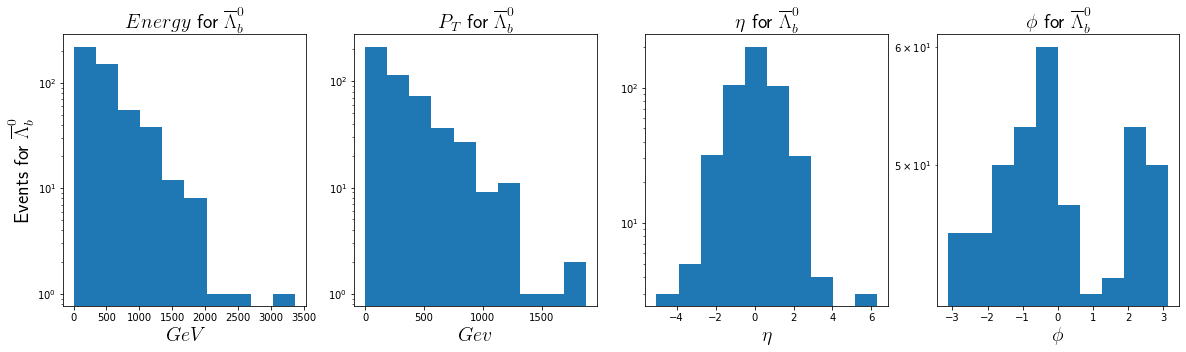

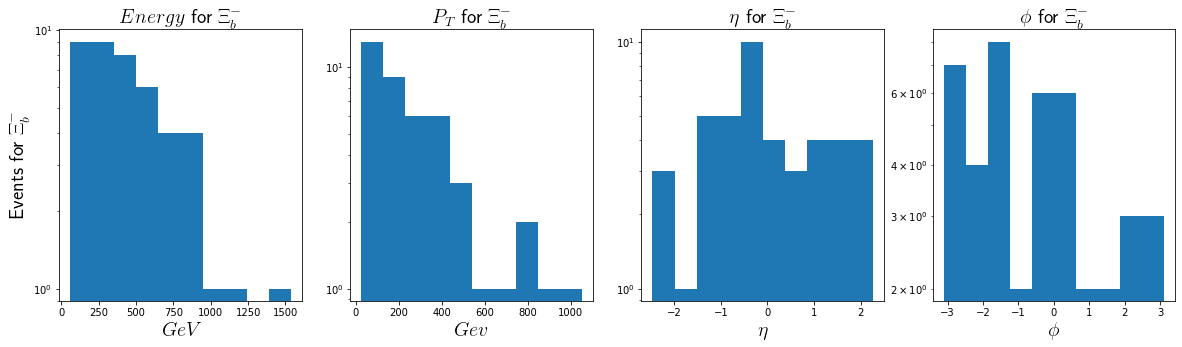

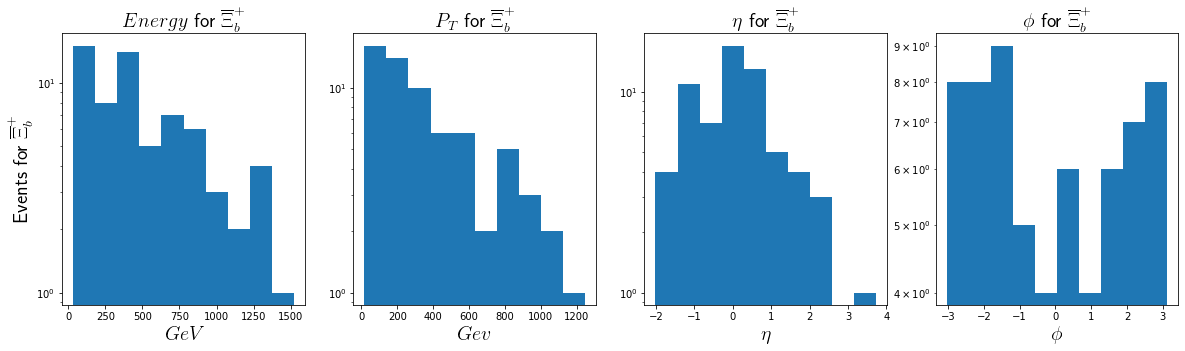

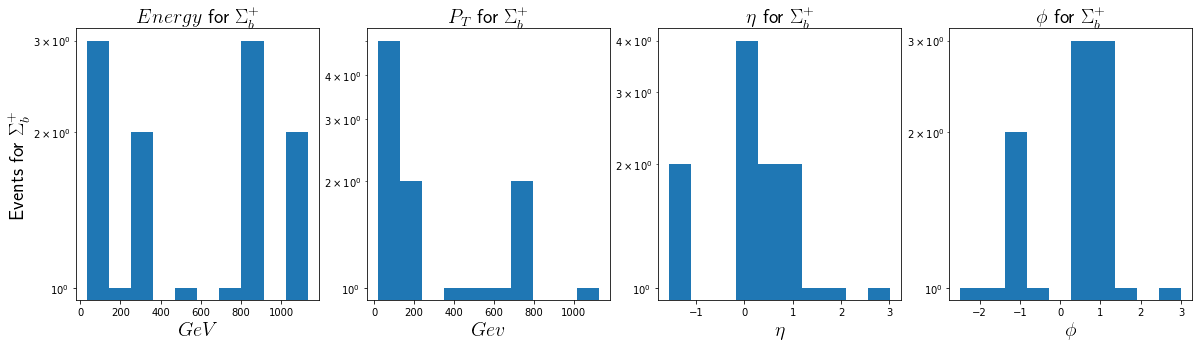

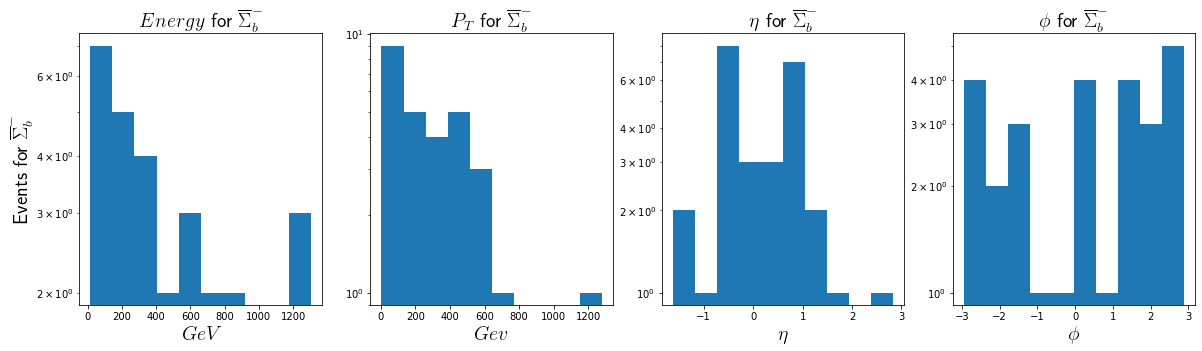

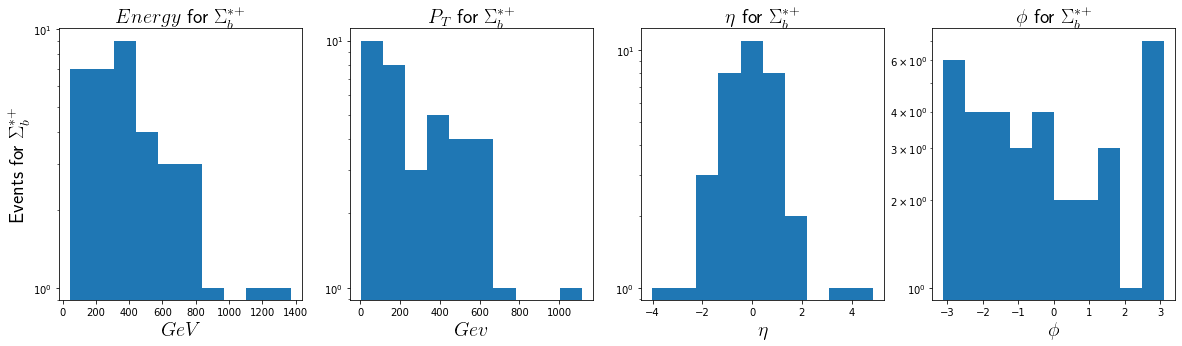

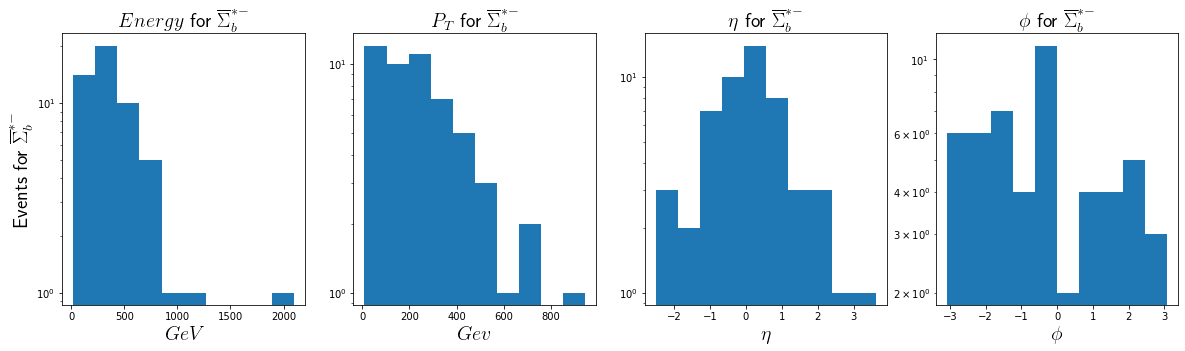

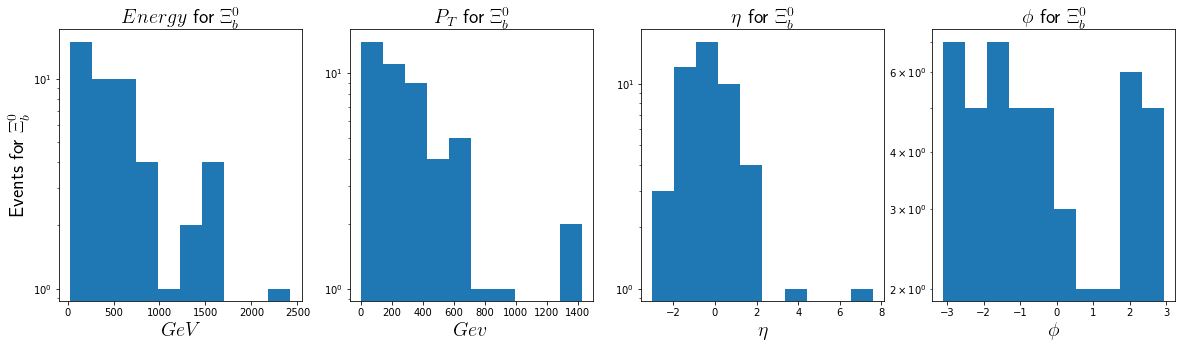

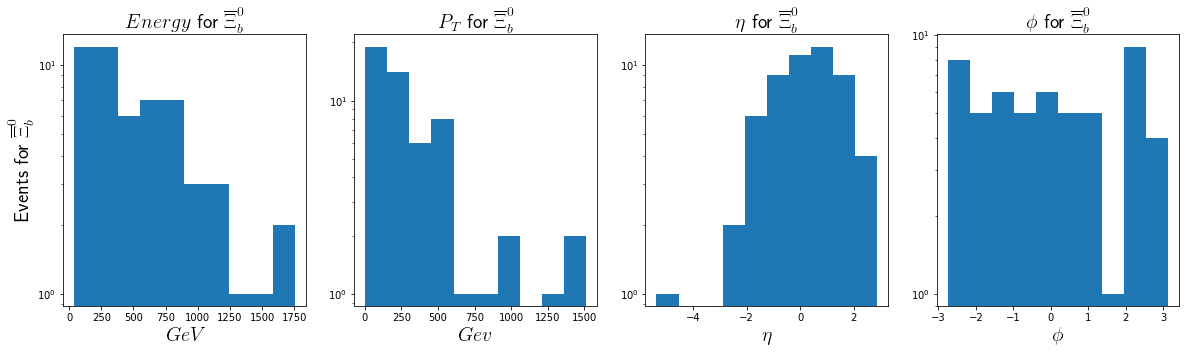

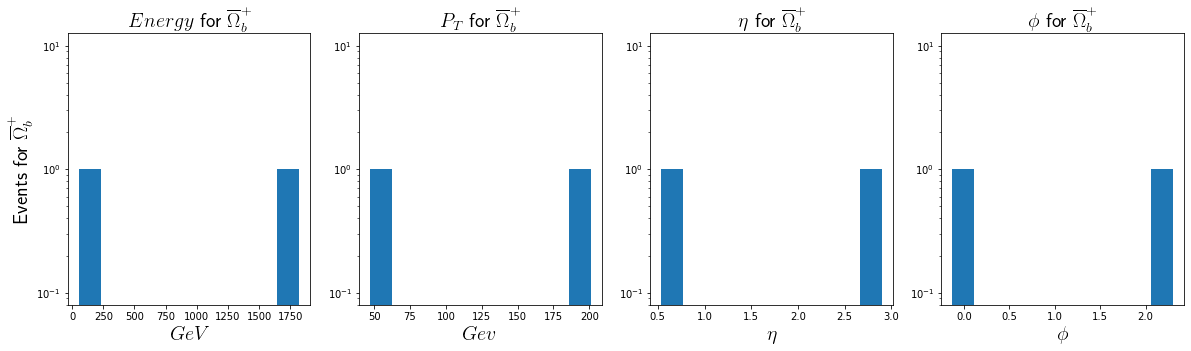

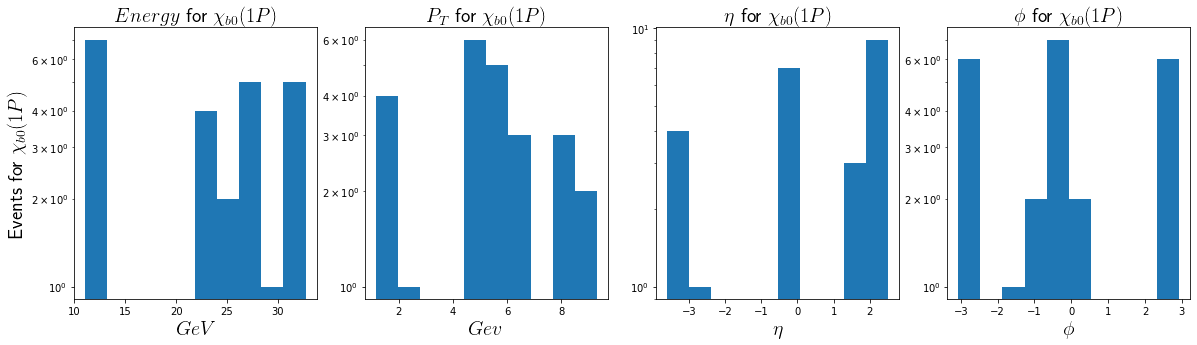

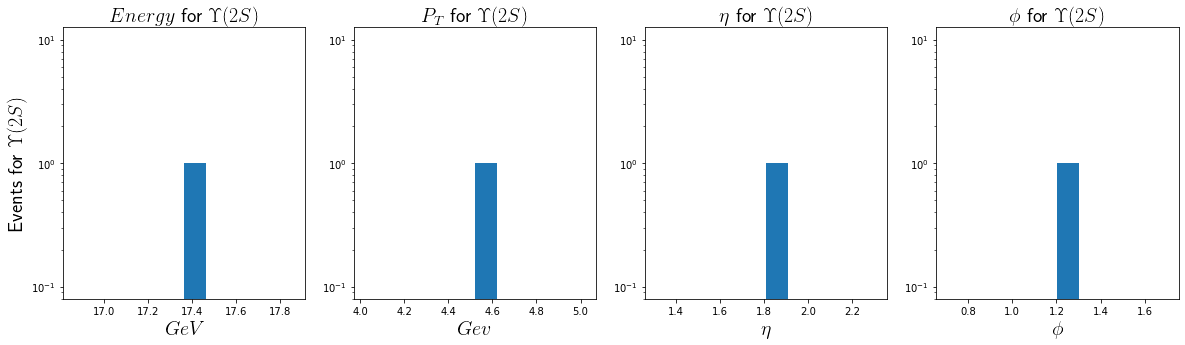

In [81]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_100.Particle
particlehists(pdgids, ctawk)

### ct_10

/tmp/ipykernel_10497/1616479394.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.subplots(1, len(fields), figsize = (5*len(fields),5))


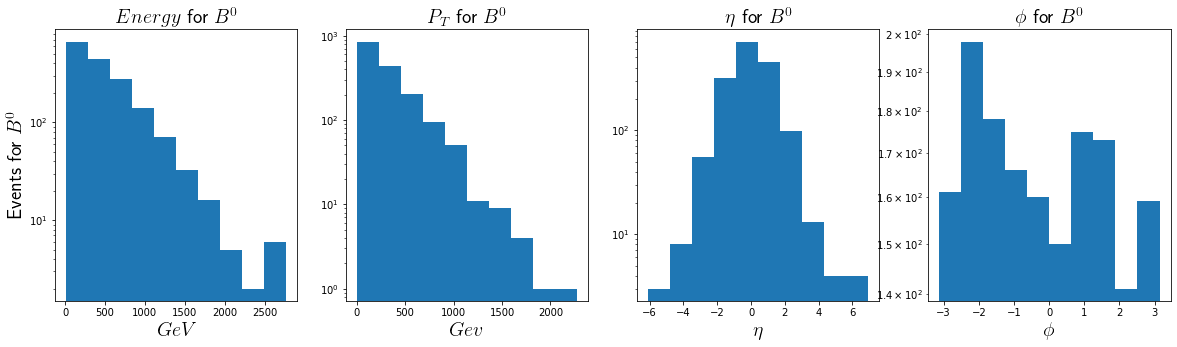

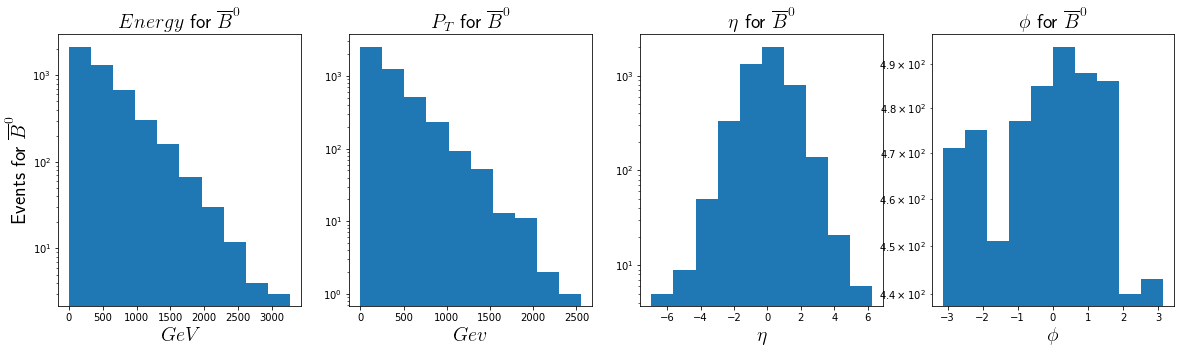

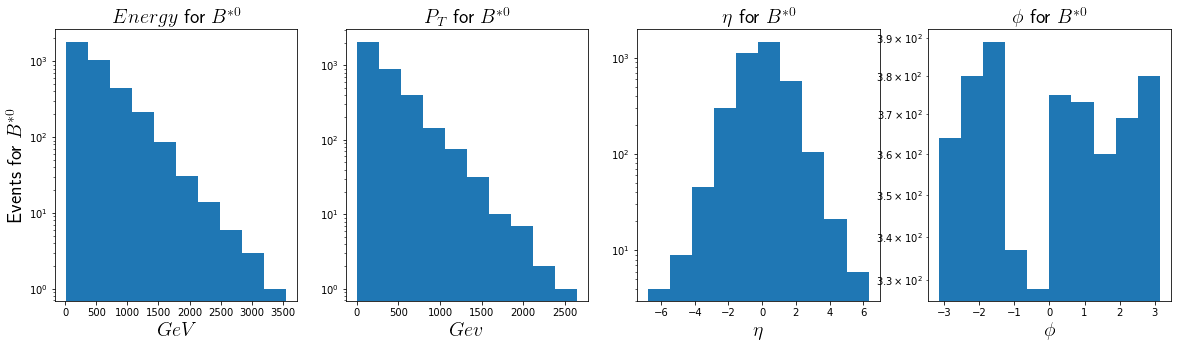

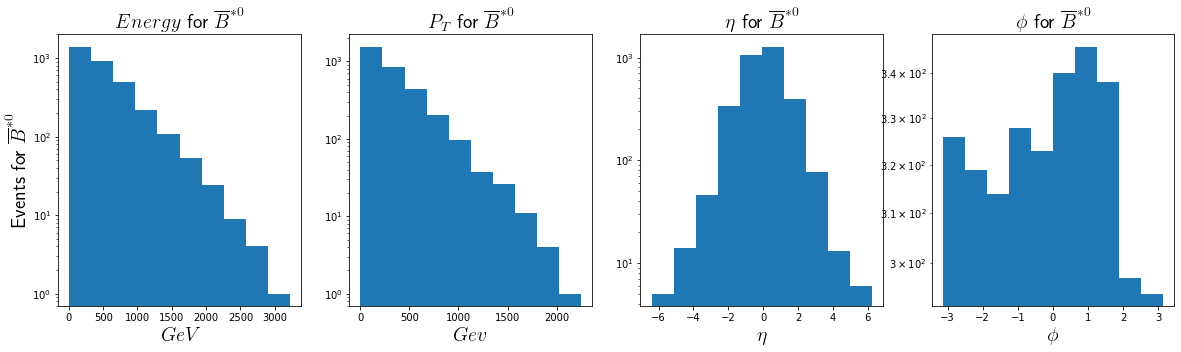

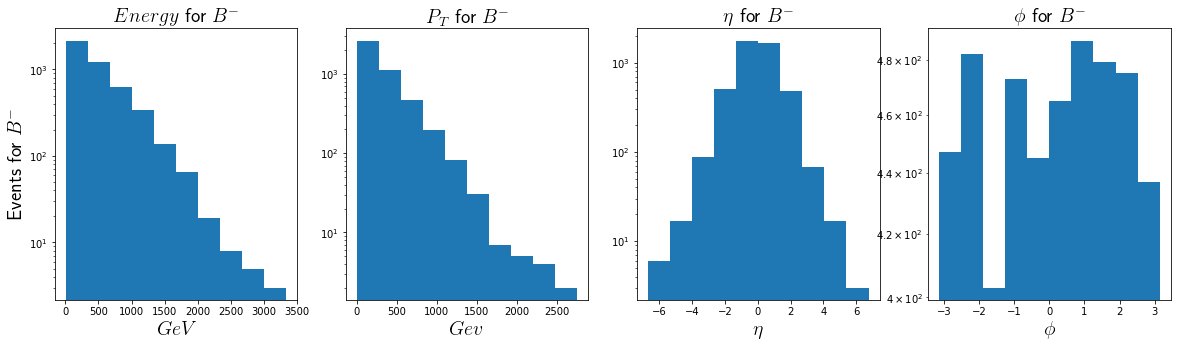

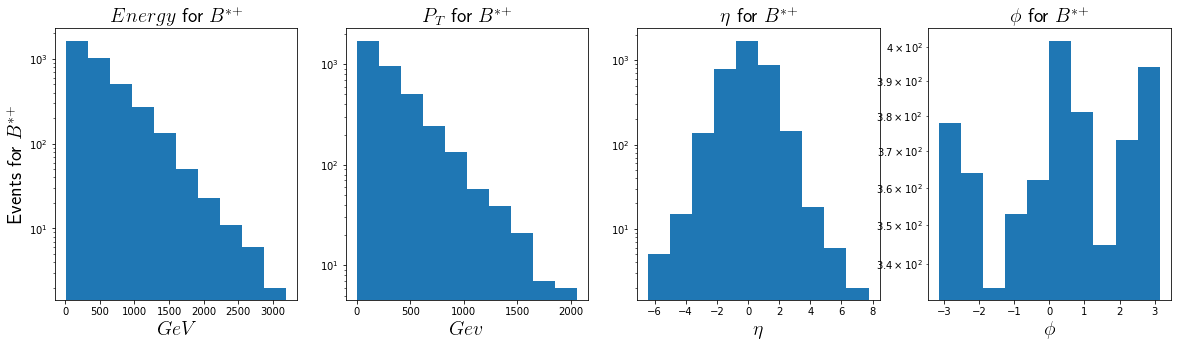

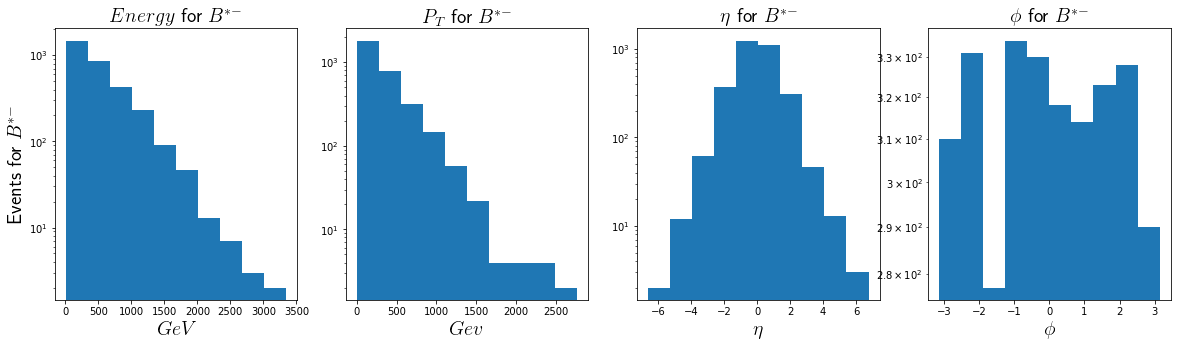

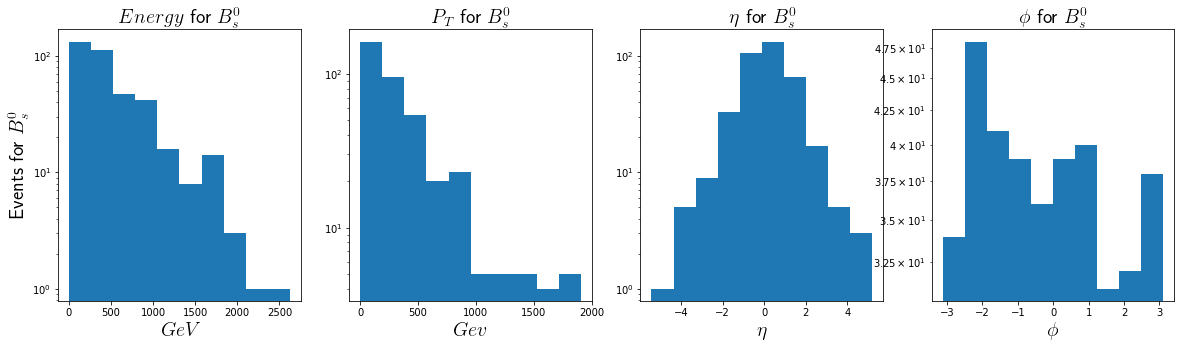

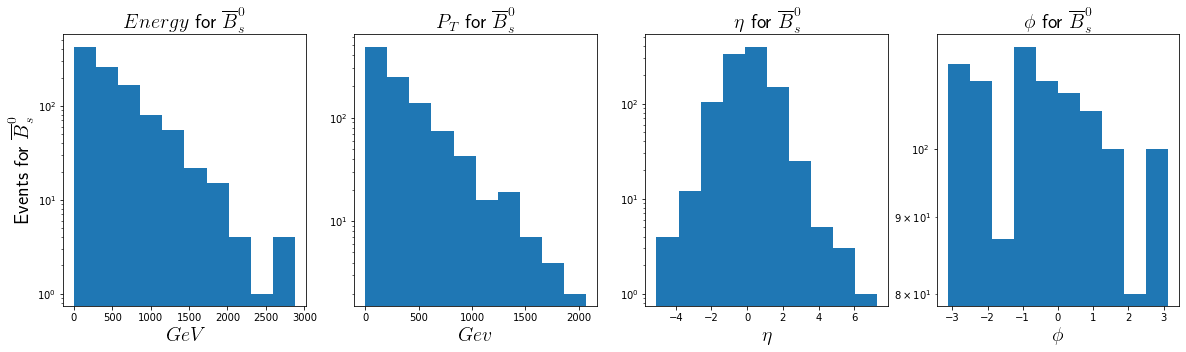

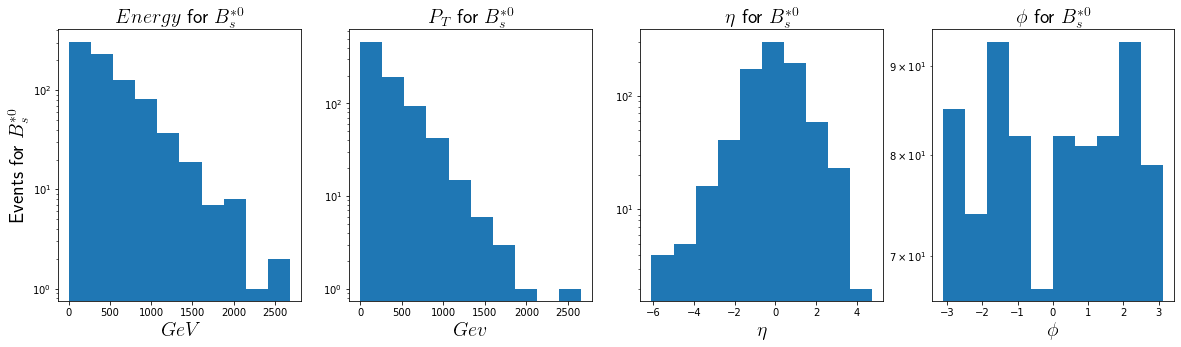

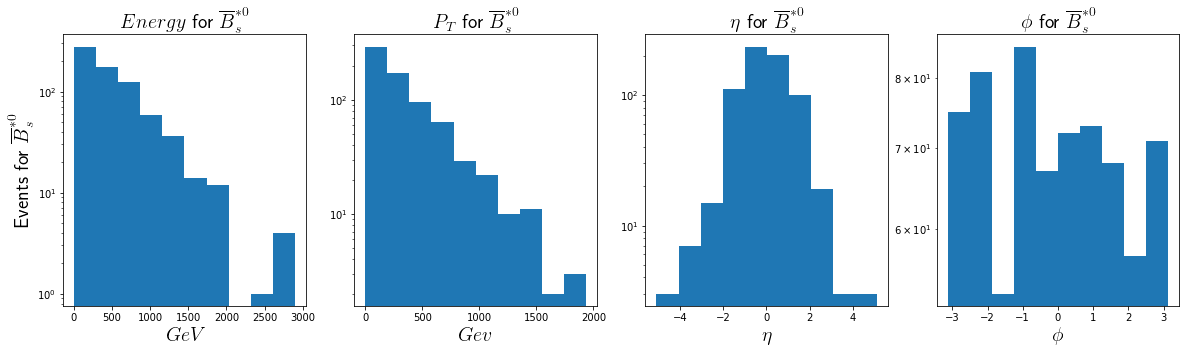

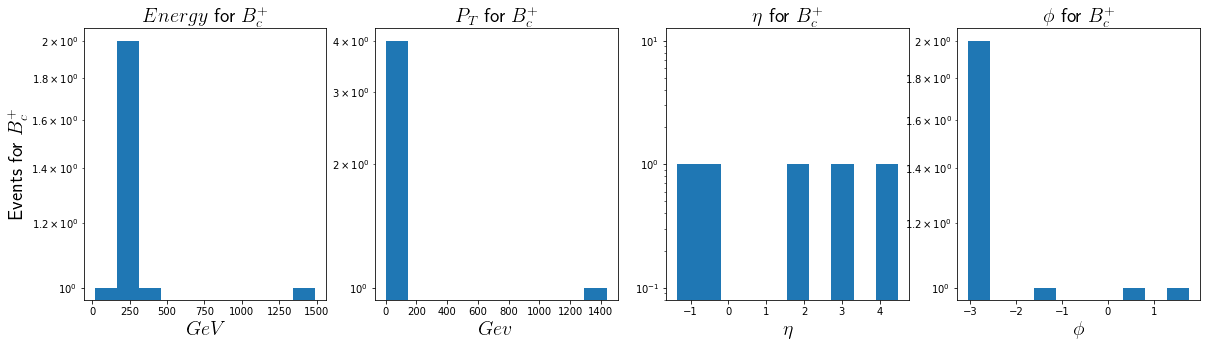

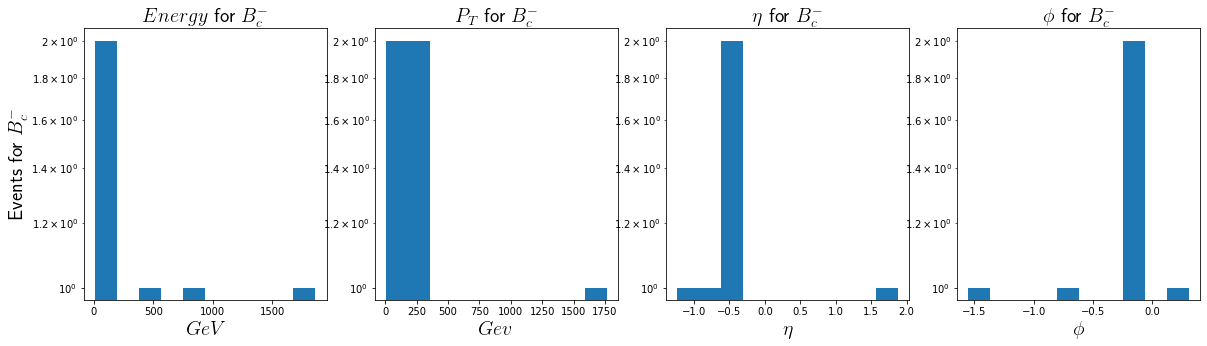

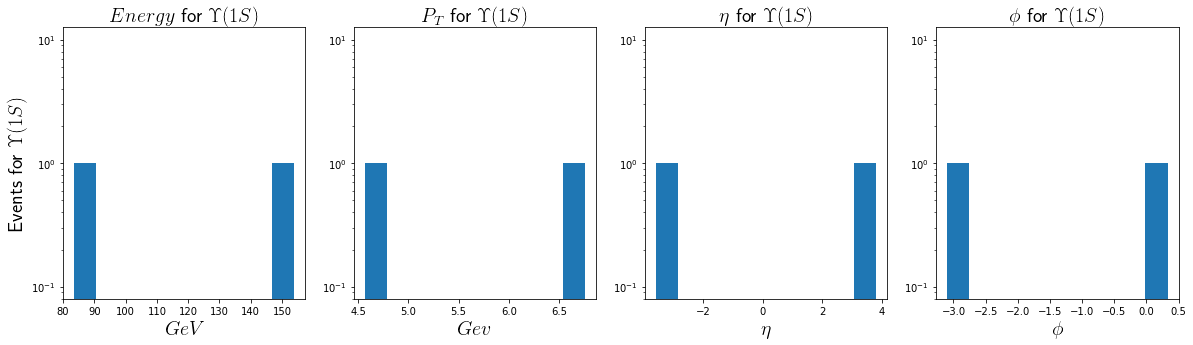

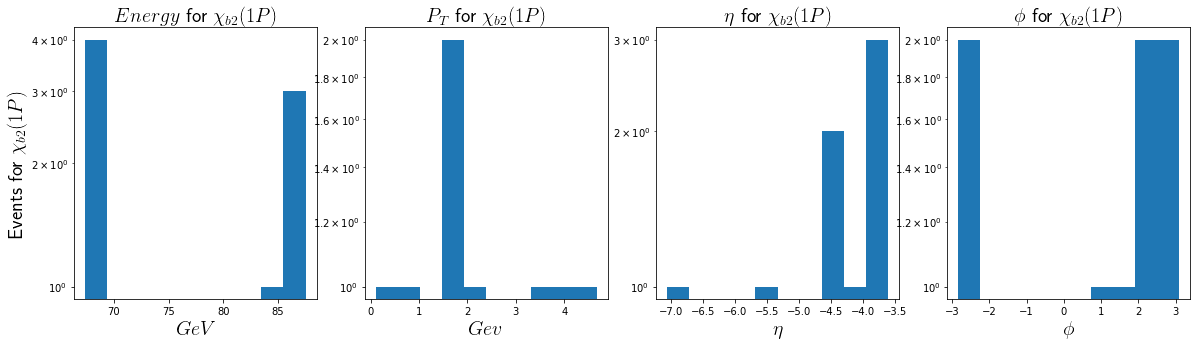

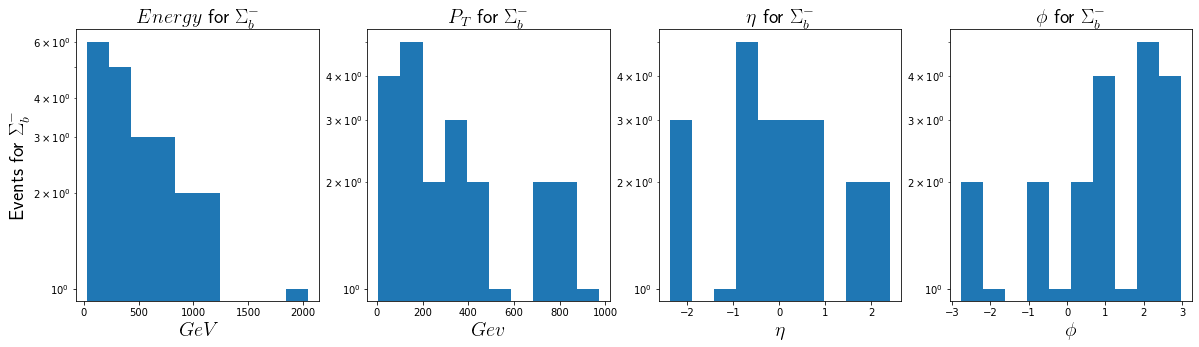

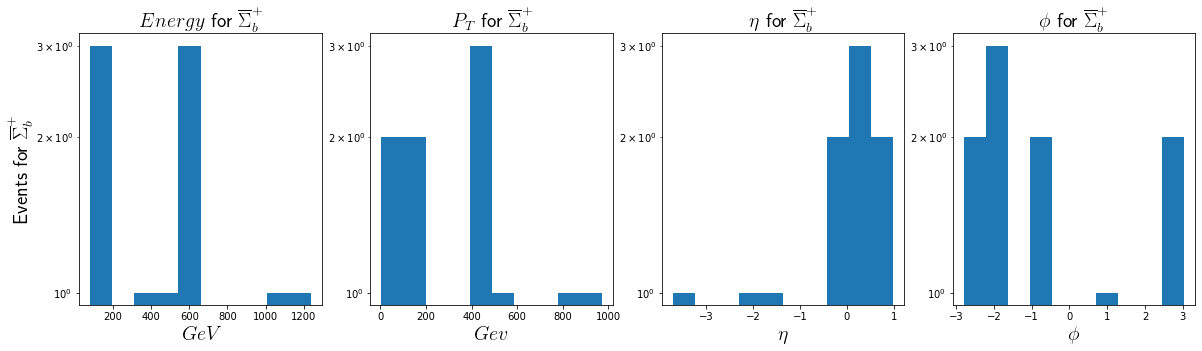

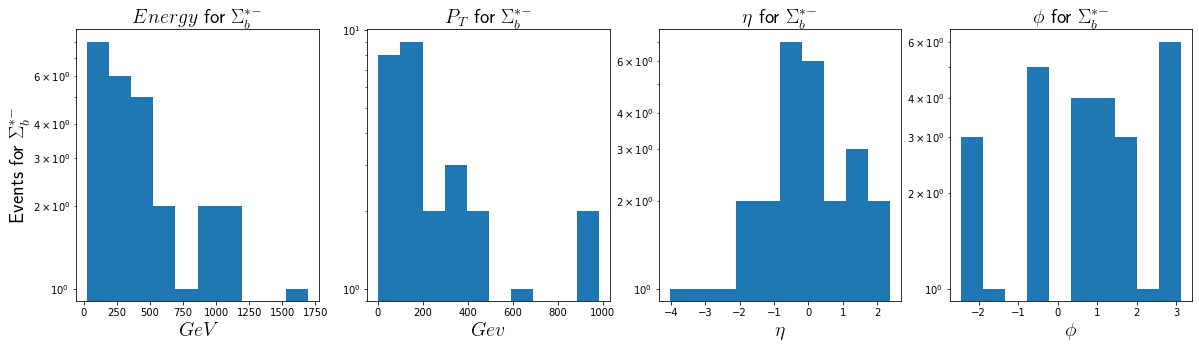

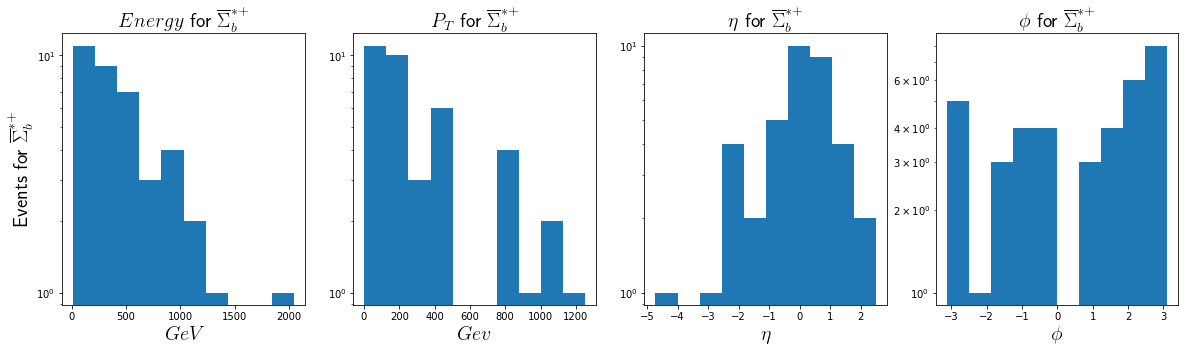

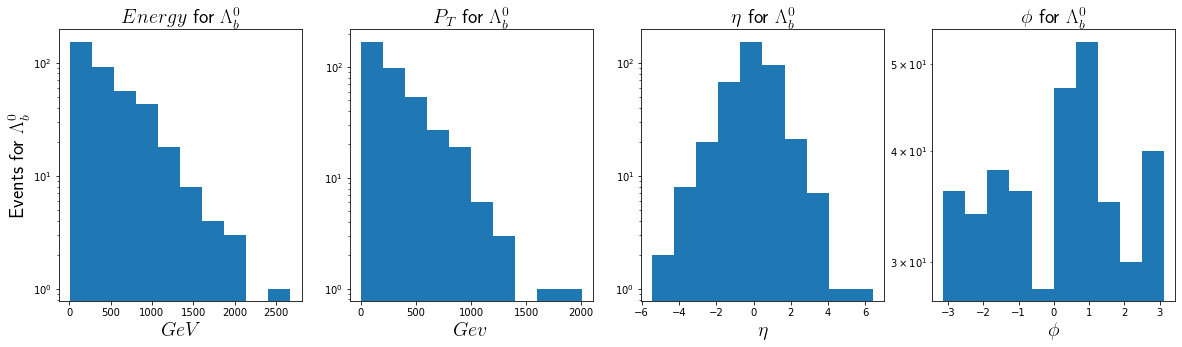

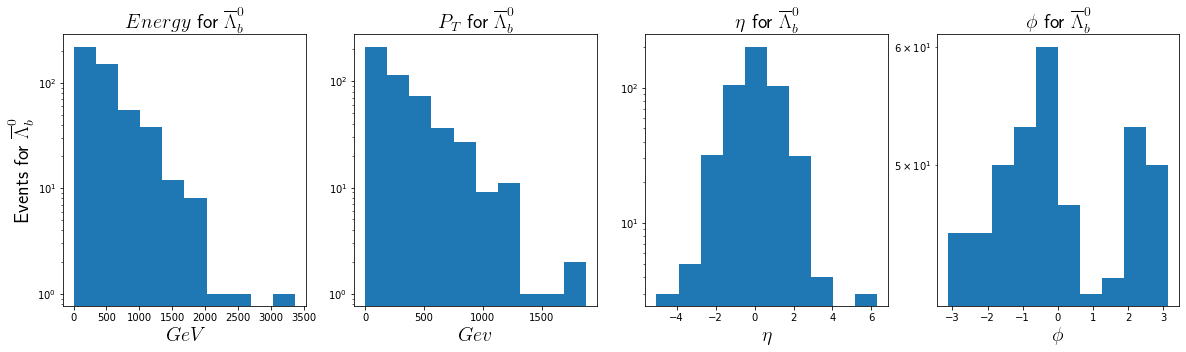

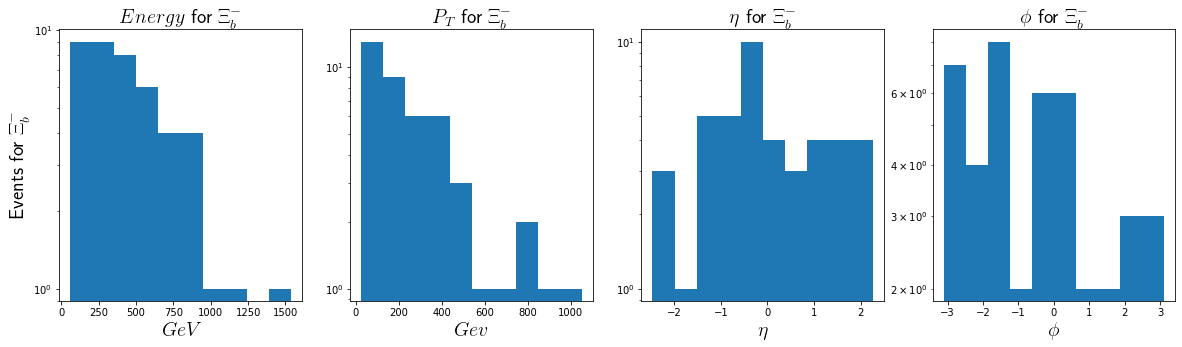

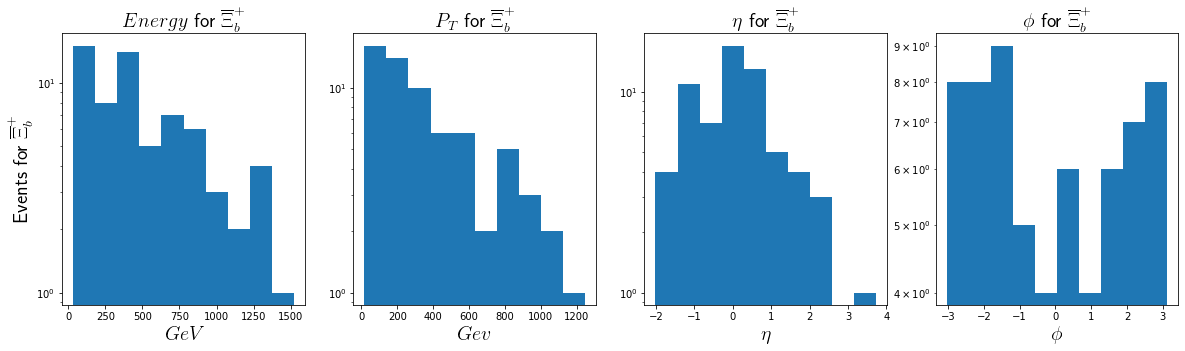

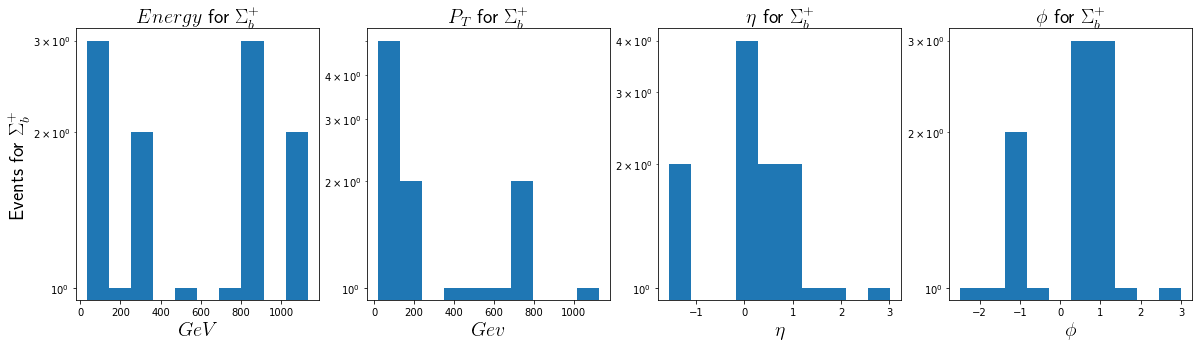

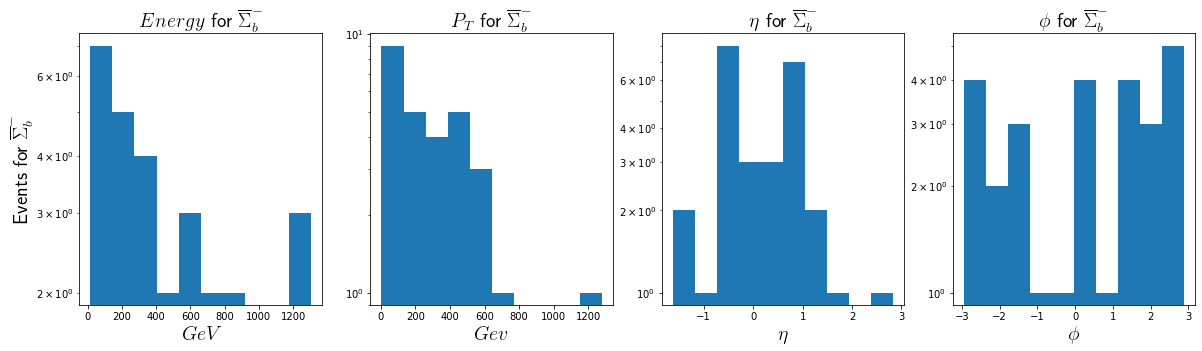

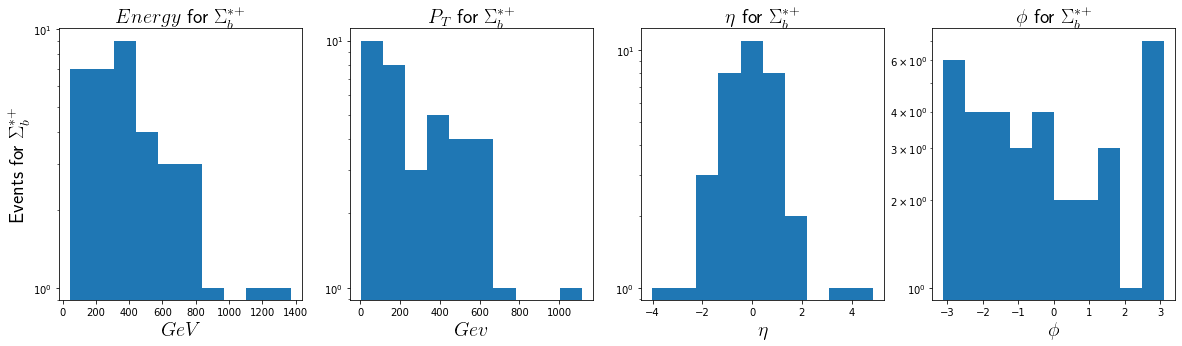

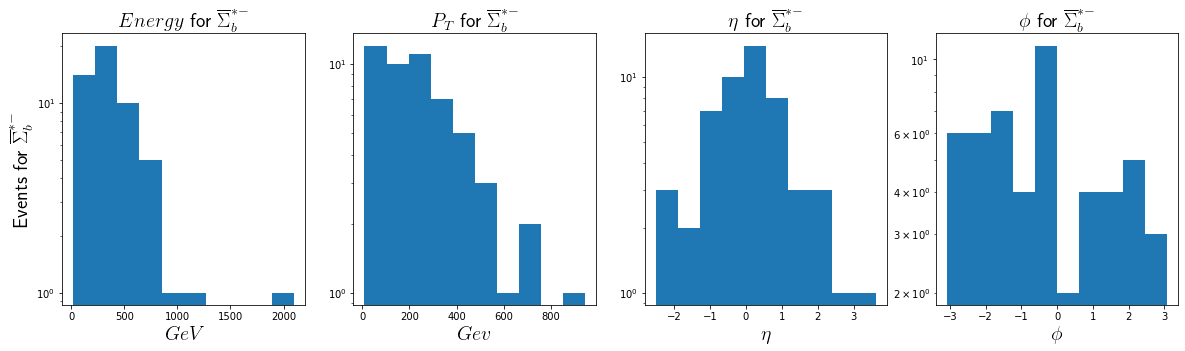

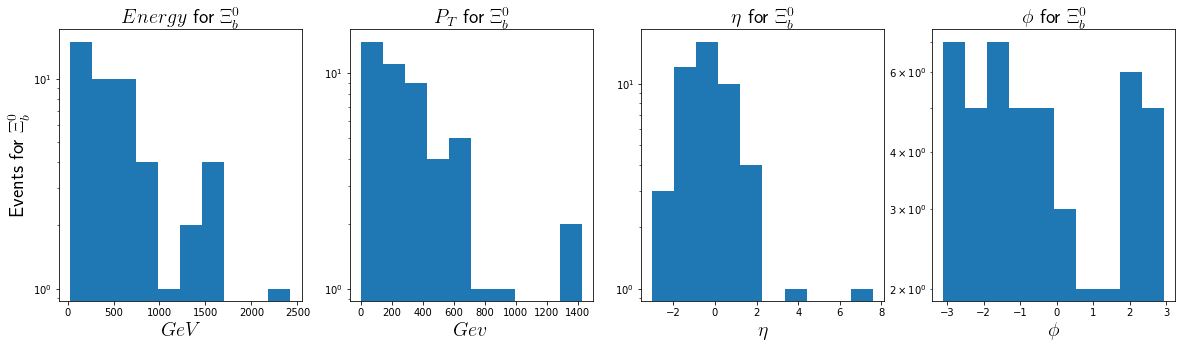

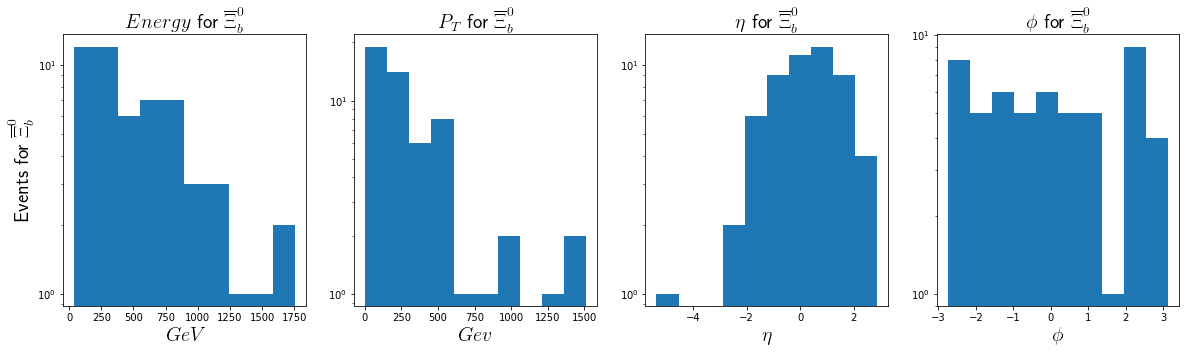

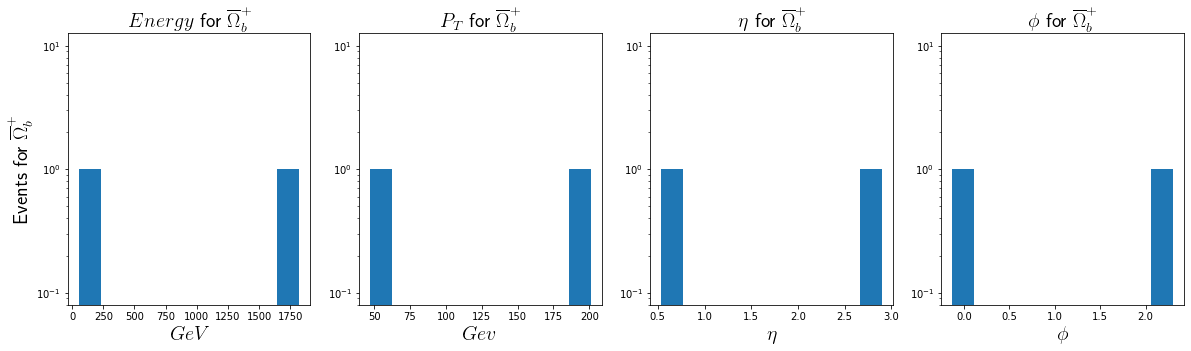

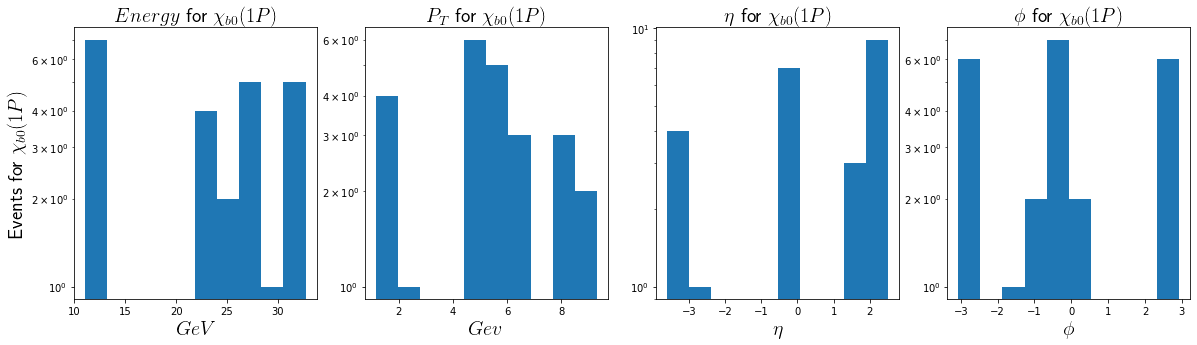

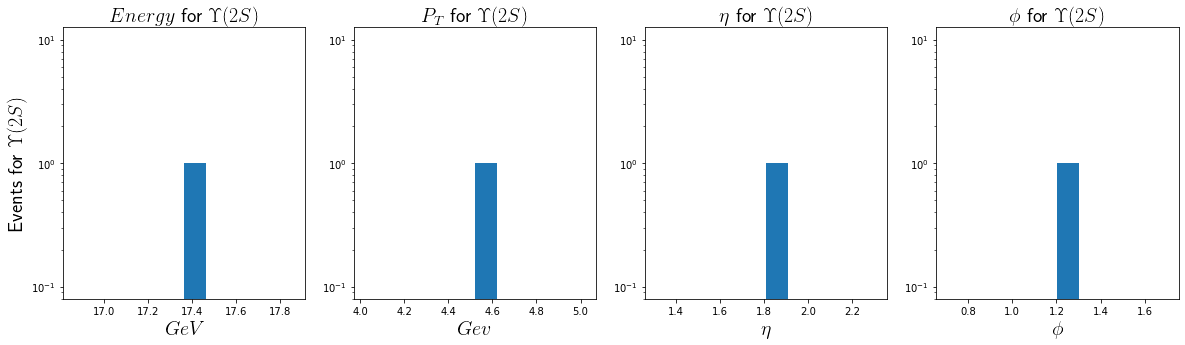

In [82]:
pdgids = list(map(lambda a: int(a.pdgid), Particle.finditer(lambda p: p.pdgid.is_hadron and (p.pdgid.has_bottom)))) #really fucky way of getting pids of B mesons
ctawk = ct_10.Particle
particlehists(pdgids, ctawk)

## LLP energy, pt, eta, phi, lab frame decay distance, rest frame decay distance

### ct_10000

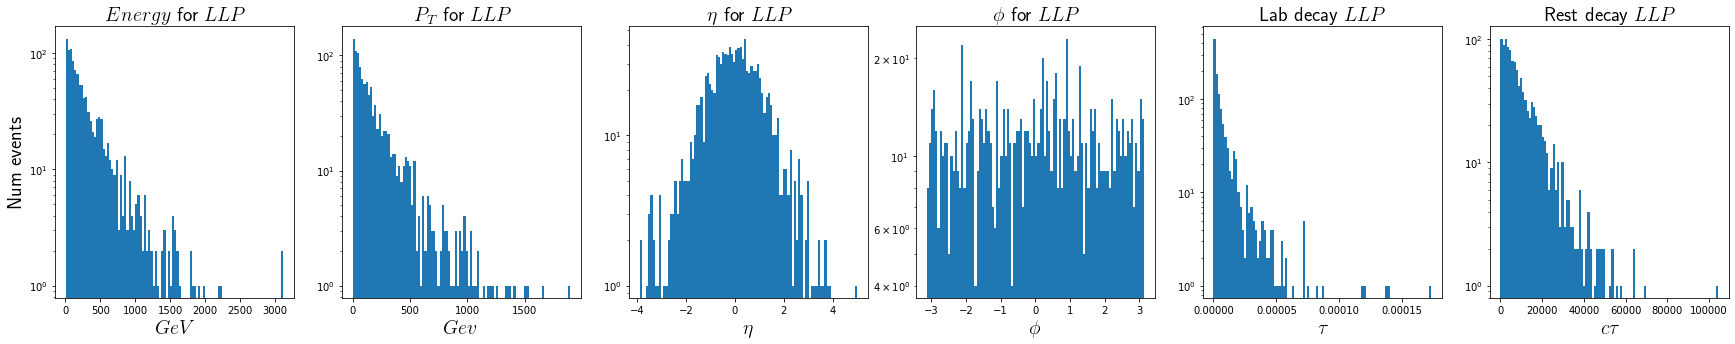

Rest Time ≈ 10864.382185705193 mm


In [140]:
pdgid = 1500001
ctawk = ct_10000.Particle
hist = llphists(pdgid, ctawk)
print("Rest Time ≈ " + str(hist2fit(hist)) + " mm")

### ct_1000

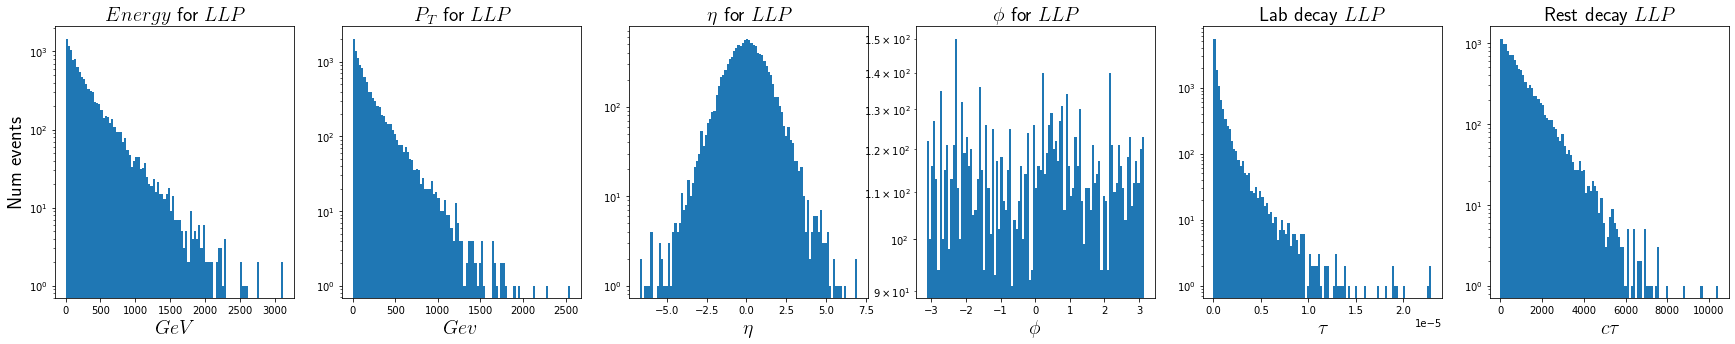

Rest Time ≈ 1008.514122682552 mm


In [139]:
pdgid = 1500001
ctawk = ct_1000.Particle
hist = llphists(pdgid, ctawk)
print("Rest Time ≈ " + str(hist2fit(hist)) + " mm")

### ct_100

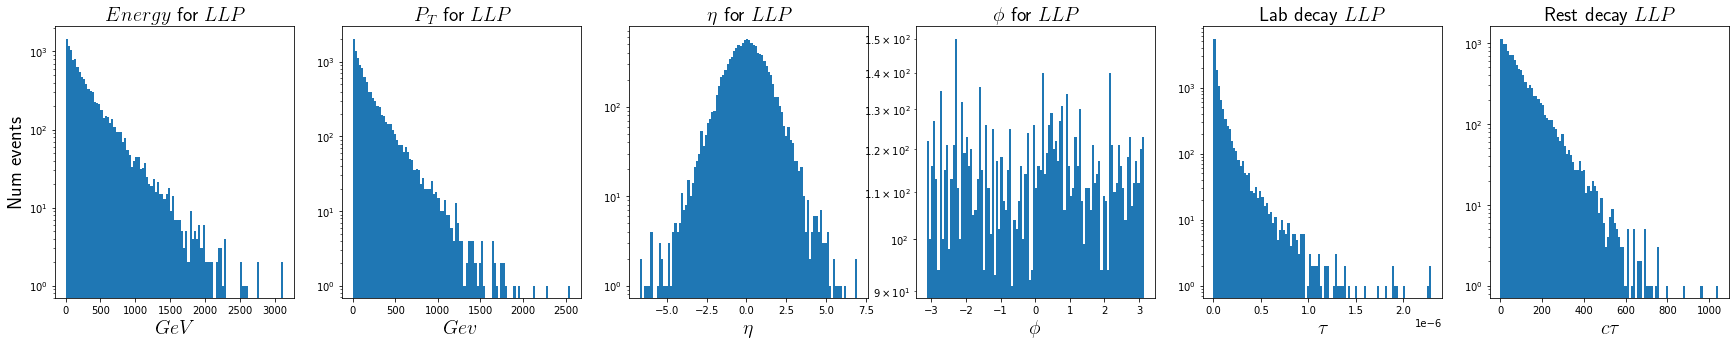

Rest Time ≈ 100.85141271562739 mm


In [141]:
pdgid = 1500001
ctawk = ct_100.Particle
hist = llphists(pdgid, ctawk)
print("Rest Time ≈ " + str(hist2fit(hist)) + " mm")

### ct_10

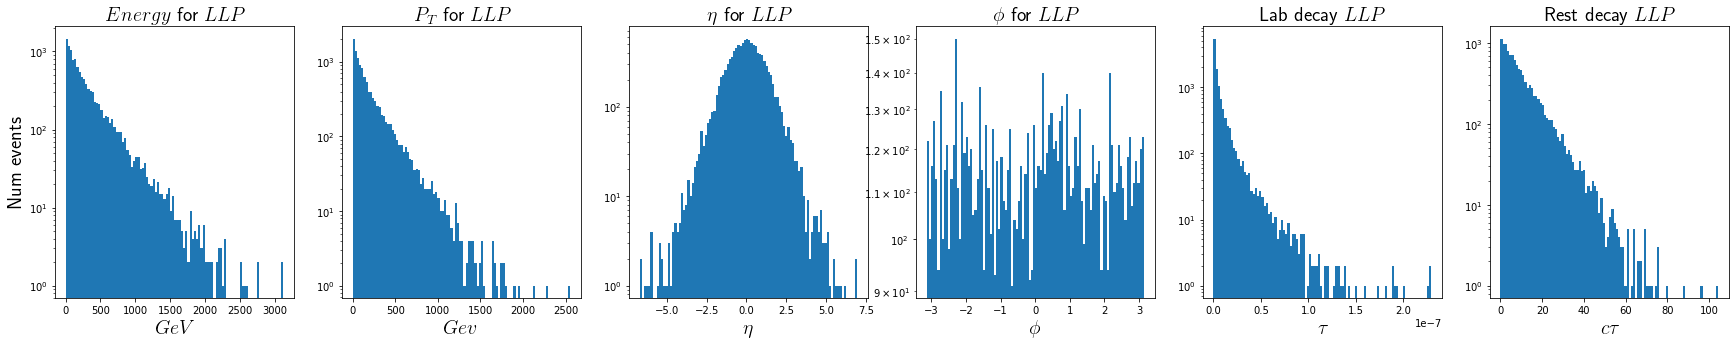

Rest Time ≈ 10.085140553699661 mm


In [142]:
pdgid = 1500001
ctawk = ct_10.Particle
hist = llphists(pdgid, ctawk)
print("Rest Time ≈ " + str(hist2fit(hist)) + " mm")

### check the acceptance of the muon system as a function of $c\tau$ TODO

### What's the typical energy fraction that the LLP carries from the B-hadron? TODO

## LLP Lab decay length and time

### ct_10000

Lab Dist  ≈ 2424909.758555159 mm
Lab Time  ≈ 2424970.984014751 mm
Rest Time ≈ 9914.793118353786 mm


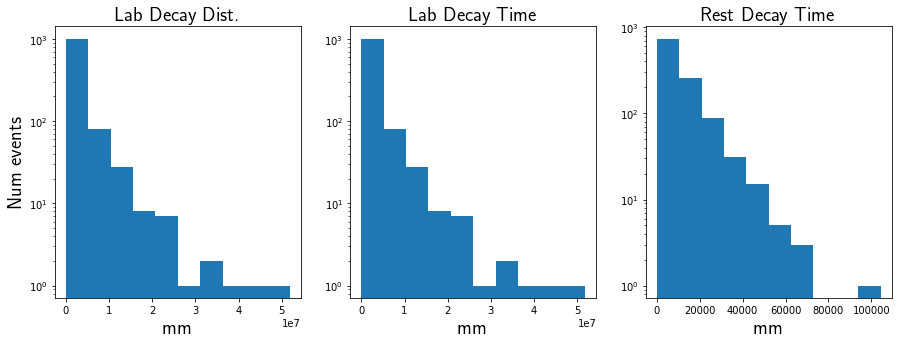

In [90]:
pdgid = 1500001
ctawk = ct_10000.Particle
labrest(pdgid, ctawk)

### ct_1000

Lab Dist  ≈ 262692.1950852933 mm
Lab Time  ≈ 262698.8835776614 mm
Rest Time ≈ 996.3548371730616 mm


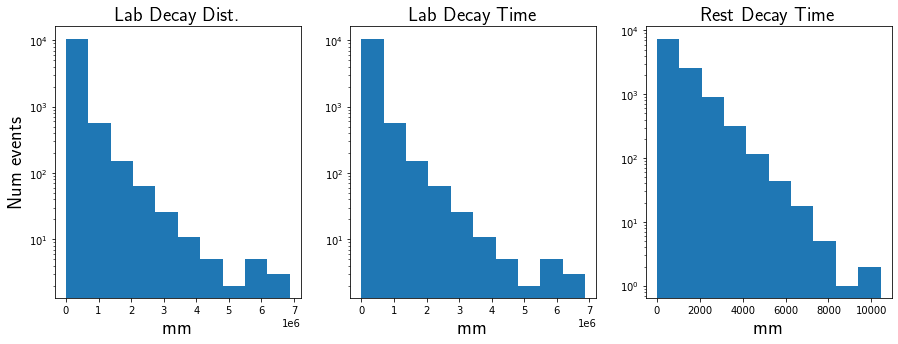

In [91]:
pdgid = 1500001
ctawk = ct_1000.Particle
labrest(pdgid, ctawk)

In [137]:
ct_10.CscCluster50.fields

['fUniqueID',
 'fBits',
 'NHits',
 'Eta',
 'Phi',
 'PT',
 'Px',
 'Py',
 'Pz',
 'E',
 'Ehad',
 'Eem',
 'pid',
 'T',
 'X',
 'Y',
 'Z',
 'R',
 'beta',
 'ctau']

### ct_100

Lab Dist  ≈ 26269.216753314948 mm
Lab Time  ≈ 26269.887852781776 mm
Rest Time ≈ 99.63548337812956 mm


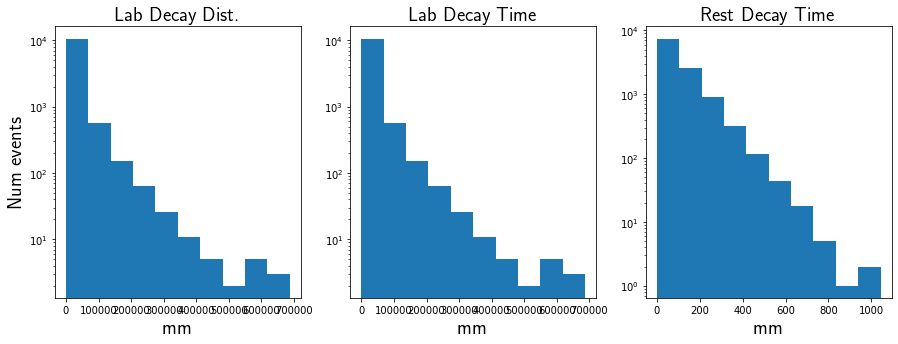

In [92]:
pdgid = 1500001
ctawk = ct_100.Particle
labrest(pdgid, ctawk)

### ct_10

Lab Dist  ≈ 2626.9217876218254 mm
Lab Time  ≈ 2626.9889040941553 mm
Rest Time ≈ 9.963547687924791 mm


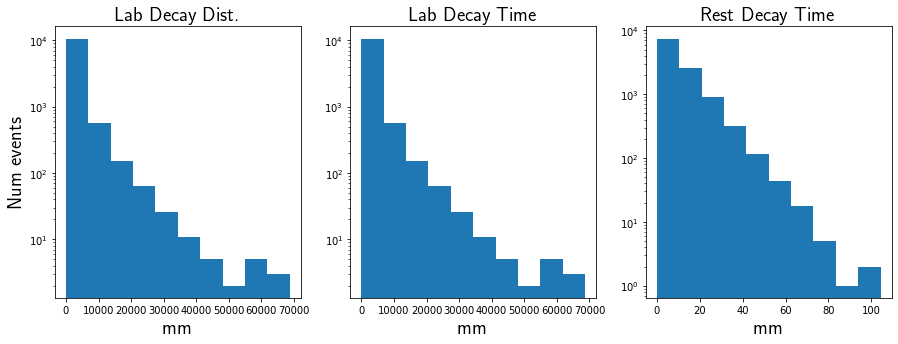

In [94]:
pdgid = 1500001
ctawk = ct_10.Particle
labrest(pdgid, ctawk)

## $\Delta R$ between LLP and Kaon (both coming from one of the B-hadrons) TODO

## ct_10000

In [120]:
llpid  = 1500001
ctawk  = ct_10000.Particle

mask = (ctawk[ctawk.D1].PID == llpid) + (ctawk[ctawk.D2].PID == llpid) 





<Array [[{D1: 1437, D2: 1438}, ... D2: 656}]] type='1000 * var * {"D1": int32[pa...'>

## Using the B-hadron that does not produce the LLP find it's the events that decay to muons. TODO

### Require the muon pt to be larger that 8 GeV and plot again the LLP kinematic variables TODO


## Now using the delphes module from check the LLP reconstruction efficiency when the LLP decays in the muon system. Todo

## Check if there is any jet in the vicinity of the LLP cluster using deltaR matching. TODO

### What's the typical energy of the jet that is match and how close are they to the LLP  in eta, phi. TODO

In [372]:
df = ak.to_pandas(events[0].Particle[["PID","D1","D2","M1","M2","Status","PT","Eta","Phi","ctau"]])

for i in range(len(df)):
    try: # dont do this at home
        df["PID"][i]= pt.from_pdgid(PID(df["PID"][i]).to_pdgid())
    except:
        print(df["PID"][i])
    
qgrid.show_grid(df)

1500001


/tmp/ipykernel_4265/2944105905.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PID"][i]= pt.from_pdgid(PID(df["PID"][i]).to_pdgid())


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [ ]:
shower = events[0].Particle #an event

tree = {}
for i in range(len(shower)):
    particle = shower[i]
    #d1 = particle.D1
    #d2 = particle.D2
    
    m1 = particle.M1
    m2 = particle.M2
    
    branch = {}
    
    if m1 != -1:
        branch[m1] = {}
    if m2 != -1:
        branch[m2] = {}
    #if d1 != -1:
    #    branch[d1] = {}
    #if d2 != -1:
    #    branch[d2] = {}
        
    
    tree[i] = branch

In [ ]:
T = nx.DiGraph(tree)
nx.draw_kamada_kawai(T, node_size = 10)